# Results

## Benefits of Finetuning

In [1]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import joblib
import __init__

Navigated to package root: /home/cyprien/CrystaLLMv2_PKV
Added package root to Python path


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib.ticker import MaxNLocator
from scipy.stats import gaussian_kde

OKABE_ITO = {"Slider":"#E69F00","PKV":"#990099","Prepend":"#56B4E9","Raw":"#000000"}

def _method_pretrain(lbl):
    l = lbl.lower()
    if   "slider"  in l: m = "Slider"
    elif "pkv"     in l: m = "PKV"
    elif "prepend" in l: m = "Prepend"
    else:                m = "Raw"
    return m, ("scratch" not in l)

def make_conditional_performance_plot(
    df_dict, *,
    train_df=None,
    train_bg_col="Bandgap (eV)",
    pred_bg_col="ALIGNN_bg (eV)",
    target_bg_col="target_Bandgap (eV)",
    cond_col="target_Bandgap (eV)",
    hit_tol_eV=0.2,
    xlim=None,
    ylim_hit=None,
    ylim_valid=None,
    ylim_q=None,
    savepath=None,
    # --- New size arguments for paper-ready plot ---
    label_fontsize=16,
    title_fontsize=18,
    ticks_fontsize=14,
    legend_fontsize=14,
    mean_fontsize=12,
    line_width=2.2,
    marker_size=7,
    scatter_size=100,
    scatter_lw=2.0,
    axes_thickness=1.5
):
    # 1) Gather all condition values
    conds = set()
    for d in df_dict.values():
        if cond_col in d.columns:
            conds.update(d[cond_col].dropna().unique())
    conds = sorted(map(float, conds))
    
    # 2) Build summary rows including n, hit count, valid frac, Q fraction
    rows = []
    for lbl, df in df_dict.items():
        meth, pre = _method_pretrain(lbl)
        if cond_col not in df.columns:
            df = df.assign(**{cond_col: [np.nan]*len(df)})
        # print(df.columns)
        # if "is_stable_mace" not in df.columns:
        
        tau = 0.157

        eh = pd.to_numeric(df["ehull_mace_mp"], errors="coerce")
        df["is_stable_mace"] = eh.le(tau)  # row-wise ≤ τ; NaNs → False

        # make sure the columns are numeric
        for c in conds or [np.nan]:
            sub = df[df[cond_col] == c].copy() if not pd.isna(c) else df.copy()
            n = len(sub)
            if n == 0:
                rows.append({"m":meth,"p":pre,"x":c,"n":0,"hit":np.nan,"valid":np.nan,"q":np.nan})
                continue
            # hit COUNT
            hit = np.nan
            if {pred_bg_col,target_bg_col}.issubset(sub.columns):
                pred = pd.to_numeric(sub[pred_bg_col],errors="coerce")
                true = pd.to_numeric(sub[target_bg_col],errors="coerce")
                mask = (pred-true).abs() <= hit_tol_eV
                hit = mask.mean()
            # valid fraction
            valid = sub["is_valid"].mean() if "is_valid" in sub.columns else np.nan
            # Q = valid ∧ unique ∧ novel ∧ stable_orb
            # make an is_stable_mace column if it doesn't exist
            q = np.nan
            req = {"is_valid","is_unique","is_novel","is_stable_mace"}
            if req.issubset(sub.columns):
                mask_q = sub["is_valid"] & sub["is_unique"] & sub["is_novel"] & sub["is_stable_mace"]
                q = mask_q.mean()
            rows.append({"m":meth,"p":pre,"x":c,"n":n,"hit":hit,"valid":valid,"q":q})
    met = pd.DataFrame(rows)
    
    # 3) Compute KDE on training to get scaled density
    dens_interp = None
    if train_df is not None and train_bg_col in train_df.columns and len(train_df)>50:
        vals = pd.to_numeric(train_df[train_bg_col],errors="coerce").dropna()
        kde = gaussian_kde(vals,bw_method="scott")
        xs = np.linspace(vals.min(),vals.max(),400)
        dens = kde(xs)
        dens_norm = dens/dens.max()
        dens_interp = np.interp(met["x"].astype(float), xs, dens_norm)
    
    # 4) Plotting
    fig, (ax_hit, ax_valid, ax_q) = plt.subplots(1,3,figsize=(18,6),constrained_layout=True)
    # overlay density on hit‐count axis
    if dens_interp is not None:
        axd = ax_hit.twinx()
        axd.plot(xs, dens_norm, color="gray", lw=line_width, ls=":")
        axd.set_ylim(0,1)
        axd.set_ylabel("Density (scaled)", fontsize=label_fontsize)
        # --- MODIFIED LINE FOR SECONDARY Y-AXIS ---
        axd.yaxis.set_major_locator(MaxNLocator(nbins=4, prune="upper"))
        for sp in ("right","top"): axd.spines[sp].set_visible(False)
        met["density"] = dens_interp
        axd.tick_params(axis='y', which='major', labelsize=ticks_fontsize)

    ymax = {"hit":0,"valid":0,"q":0}
    for meth,col in OKABE_ITO.items():
        for pre,ls,mk in ((True,"-","o"),(False,"--","^")):
            sub = met[(met.m==meth)&(met.p==pre)]
            # hit count
            if sub["hit"].notna().any():
                ax_hit.plot(sub.x,sub.hit,ls,color=col,marker=mk,ms=marker_size,lw=line_width)
                ymax["hit"] = max(ymax["hit"], sub.hit.max())
            # valid
            if sub["valid"].notna().any():
                ax_valid.plot(sub.x,sub.valid,ls,color=col,marker=mk,ms=marker_size,lw=line_width)
                ymax["valid"] = max(ymax["valid"], sub.valid.max())
            # Q
            if sub["q"].notna().any():
                ax_q.plot(sub.x,sub.q,ls,color=col,marker=mk,ms=marker_size,lw=line_width)
                ymax["q"] = max(ymax["q"], sub.q.max())
    # summary markers
    x_max = max(conds) if conds else 0
    x_base = x_max + 0.5
    for meth,col in OKABE_ITO.items():
        for pre,mk,fc in ((True,"o",col),(False,"^","none")):
            sub = met[(met.m==meth)&(met.p==pre)]
            if sub.hit.notna().any():
                ax_hit.scatter(x_base, sub.hit.mean(),marker=mk,edgecolor=col,
                               facecolor=fc,s=scatter_size,lw=scatter_lw,zorder=5)
            if sub.valid.notna().any():
                ax_valid.scatter(x_base, sub.valid.mean(),marker=mk,edgecolor=col,
                                 facecolor=fc,s=scatter_size,lw=scatter_lw,zorder=5)
            if sub.q.notna().any():
                ax_q.scatter(x_base, sub.q.mean(),marker=mk,edgecolor=col,
                             facecolor=fc,s=scatter_size,lw=scatter_lw,zorder=5)
    # set limits and styles
    for ax,name in zip((ax_hit,ax_valid,ax_q),("hit","valid","q")):
        ax.set_xlim(0, x_base+0.5)
        lim = locals()[f"ylim_{name}"]
        ax.set_ylim(*(lim if lim else (0, ymax[name]*1.1)))
        
        ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
        
        # --- MODIFIED LINES FOR MAIN Y-AXES ---
        # Set a maximum of 5 ticks and remove the top one if it's too close to the edge.
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune="upper"))
        # Set ticks for the x-axis
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune="upper"))

        # ADD THESE LINES TO SET AXES THICKNESS:
        for spine in ax.spines.values():
            spine.set_linewidth(axes_thickness)
        
        for sp in ("right","top"): ax.spines[sp].set_visible(False)
        ax.text(x_base, ax.get_ylim()[0] - 0.02*(ax.get_ylim()[1]-ax.get_ylim()[0]),
                "mean", ha="center", va="top", fontsize=mean_fontsize)

    # titles
    ax_hit.set_title("Target hits vs. target band-gap", fontsize=title_fontsize)
    ax_hit.set_ylabel("Fraction target hits", fontsize=label_fontsize)
    ax_hit.set_xlabel("Target band-gap [eV]", fontsize=label_fontsize)
    ax_valid.set_title("Fraction valid generations", fontsize=title_fontsize)
    ax_valid.set_ylabel("Fraction", fontsize=label_fontsize)
    ax_valid.set_xlabel("Target band-gap [eV]", fontsize=label_fontsize)
    ax_q.set_title("Generation quality $Q_{\\mathrm{VSUN}}$", fontsize=title_fontsize)
    ax_q.set_ylabel("$Q_{\\mathrm{VSUN}}$ (fraction)", fontsize=label_fontsize)
    ax_q.set_xlabel("Target band-gap [eV]", fontsize=label_fontsize)
    # legends
    solid  = lines.Line2D([],[],color="black",lw=line_width*1.2)
    dashed = lines.Line2D([],[],color="black",lw=line_width*1.2,ls="--")
    dotted = lines.Line2D([],[],color="gray", lw=line_width*1.2,ls=":")
    leg = ax_hit.legend([solid,dashed,dotted],
        ["With pre-training","Without pre-training","Training distribution"],
        loc="upper center",frameon=False, fontsize=legend_fontsize)
    color_handles = [lines.Line2D([],[],color=c,lw=line_width*2) for c in OKABE_ITO.values()]
    ax_q.legend(color_handles,list(OKABE_ITO.keys()),
                loc="upper center",frameon=False,title="Method", 
                fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    ax_hit.add_artist(leg)

    if savepath: fig.savefig(savepath,dpi=500, bbox_inches='tight')
    
    # === POST-PLOT METRICS ===

    met = met[met["n"] > 0].copy()
    met["hit_rate"] = met["hit"]

    # (1) hit-rate vs density fit
    if "density" in met:
        d = met["density"]
        a_h, b_h = np.polyfit(d, met["hit_rate"], 1)
        print(f"Hit-rate vs density: hit_rate = {a_h:.3f}·density + {b_h:.3f}")
        # Pearsons r
        r = np.corrcoef(d, met["hit_rate"])[0,1]
        print(f"Pearson's r = {r:.3f} (density vs hit_rate)")

    # (2) avg difference (pretrained − scratch) for valid & quality, with SEM
    diffs_valid = []
    diffs_q     = []
    for m in met.m.unique():
        grp = met[met.m == m]
        vp = grp[grp.p]["valid"].mean()
        vs = grp[~grp.p]["valid"].mean()
        qp = grp[grp.p]["q"].mean()
        qs = grp[~grp.p]["q"].mean()
        if not np.isnan(vp) and not np.isnan(vs):
            diffs_valid.append(vp - vs)
        if not np.isnan(qp) and not np.isnan(qs):
            diffs_q.append(qp - qs)
    if diffs_valid:
        mean_valid = np.mean(diffs_valid)
        sem_valid  = np.std(diffs_valid, ddof=1) / np.sqrt(len(diffs_valid))
        print(f"Avg Δ validity (pretrained-scratch): {mean_valid:.3f} ± {sem_valid:.3f} (SEM)")
    if diffs_q:
        mean_q = np.mean(diffs_q)
        sem_q  = np.std(diffs_q, ddof=1) / np.sqrt(len(diffs_q))
        print(f"Avg Δ quality  (pretrained-scratch): {mean_q:.3f} ± {sem_q:.3f} (SEM)")

    # (3) avg difference (pretrained − scratch) for hit_rate, with SEM
    diffs_hit = []
    for m in met.m.unique():
        grp = met[met.m == m]
        hp = grp[grp.p]["hit_rate"].mean()
        hs = grp[~grp.p]["hit_rate"].mean()
        if not np.isnan(hp) and not np.isnan(hs):
            diffs_hit.append(hp - hs)
    if diffs_hit:
        mean_hit = np.mean(diffs_hit)
        sem_hit  = np.std(diffs_hit, ddof=1) / np.sqrt(len(diffs_hit))
        print(f"Avg Δ hit_rate (pretrained-scratch): {mean_hit:.3f} ± {sem_hit:.3f} (SEM)")

    # (4) ratio of best/worst hit_rate at 6.72
    candidates = [c for c in conds if 6.0 <= c < 7.0]
    best_ratio = None
    best_c = None
    for c in candidates:
        vals = met[met.x == c]["hit_rate"].dropna()
        if len(vals) > 1 and vals.min() > 0:
            ratio = vals.max() / vals.min()
            if best_ratio is None or ratio > best_ratio:
                best_ratio = ratio
                best_c = c
    if best_ratio is not None:
        print(f"At {best_c:.2f} eV, best/worst hit_rate = {best_ratio:.2f}×")

    # (5) valid vs density & quality vs density fits
    if "density" in met:
        d = met["density"]
        a_v, b_v = np.polyfit(d, met["valid"], 1)
        a_q2, b_q2 = np.polyfit(d, met["q"], 1)
        print(f"Valid vs density: valid = {a_v:.3f}·density + {b_v:.3f}")
        print(f"Quality vs density: Q = {a_q2:.3f}·density + {b_q2:.3f}")
        # Pearsons r
        r_v = np.corrcoef(d, met["valid"])[0,1]
        r_q = np.corrcoef(d, met["q"])[0,1]
        print(f"Pearson's r = {r_v:.3f} (density vs valid)")
        print(f"Pearson's r = {r_q:.3f} (density vs quality)")

    # (6) best run (method + pretrained/scratch) for mean metrics
    for metric in ("hit_rate", "valid", "q"):
        means = met.groupby(["m", "p"])[metric].mean().dropna()
        if len(means) >= 2:
            top = means.nlargest(2)
            (m1, p1), (m2, p2) = top.index[0], top.index[1]
            v1, v2 = top.iloc[0], top.iloc[1]
            name1 = f"{m1} ({'pretrained' if p1 else 'scratch'})"
            name2 = f"{m2} ({'pretrained' if p2 else 'scratch'})"
            pct = (v1 - v2) * 100 if v2 > 0 else np.nan
            print(f"Best run for mean {metric}: {name1} ({v1:.3f}), {pct:.1f}% above {name2} ({v2:.3f})")

    return fig

In [3]:
df = pd.read_parquet("_utils/_evaluation_files/conditional_studies/ptnd-vs-scratch/ft-methods/mpdb-bg-ehull-PKV_post.parquet")
df
# show unique values in target_Bandgap (eV)
df["target_Bandgap (eV)"].unique()

array([ 0.07195162,  0.17969324,  0.68117194,  1.54675567,  2.4403221 ,
        3.72006713,  6.77618872, 12.14526636])

In [4]:
import pandas as pd
dfs = {
    "mpdb_slider_scratch":   pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/ptnd-vs-scratch/scratch-methods/mpdb_scratch-slider_post.parquet"),
    "mpdb_slider_pretrained":pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/ptnd-vs-scratch/ft-methods/mpdb-bg-ehull-slider_post.parquet"),
    "mpdb_pkv_scratch":      pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/ptnd-vs-scratch/scratch-methods/mpdb_scratch-PKV_post.parquet"),
    "mpdb_pkv_pretrained":   pd.read_parquet("test_prop.parquet"),
    "mpdb_prepend_scratch":  pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/ptnd-vs-scratch/scratch-methods/mpdb_scratch-prepend_post.parquet"),
    "mpdb_prepend_pretrained":pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/ptnd-vs-scratch/ft-methods/mpdb-bg-ehull-prepend_post.parquet"),
    "raw_tokens_scratch":    pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/ptnd-vs-scratch/raw-methods/mpdb_scratch-raw_post.parquet"),  # optional placeholder
    # "raw_tokens_pretrained": pd.read_parquet("raw_pretrained.parquet"),
}

from datasets import load_dataset

ds = load_dataset('c-bone/mpdb-2prop_clean', split='train')
train_df = ds.to_pandas()

Hit-rate vs density: hit_rate = 0.276·density + 0.026
Pearson's r = 0.780 (density vs hit_rate)
Avg Δ validity (pretrained-scratch): 0.204 ± 0.021 (SEM)
Avg Δ quality  (pretrained-scratch): 0.144 ± 0.009 (SEM)
Avg Δ hit_rate (pretrained-scratch): 0.026 ± 0.005 (SEM)
At 6.78 eV, best/worst hit_rate = 9.69×
Valid vs density: valid = 0.099·density + 0.478
Quality vs density: Q = 0.050·density + 0.072
Pearson's r = 0.173 (density vs valid)
Pearson's r = 0.216 (density vs quality)
Best run for mean hit_rate: PKV (pretrained) (0.226), 1.1% above Prepend (pretrained) (0.215)
Best run for mean valid: PKV (pretrained) (0.720), 1.1% above Prepend (pretrained) (0.709)
Best run for mean q: Prepend (pretrained) (0.198), 0.1% above PKV (pretrained) (0.196)


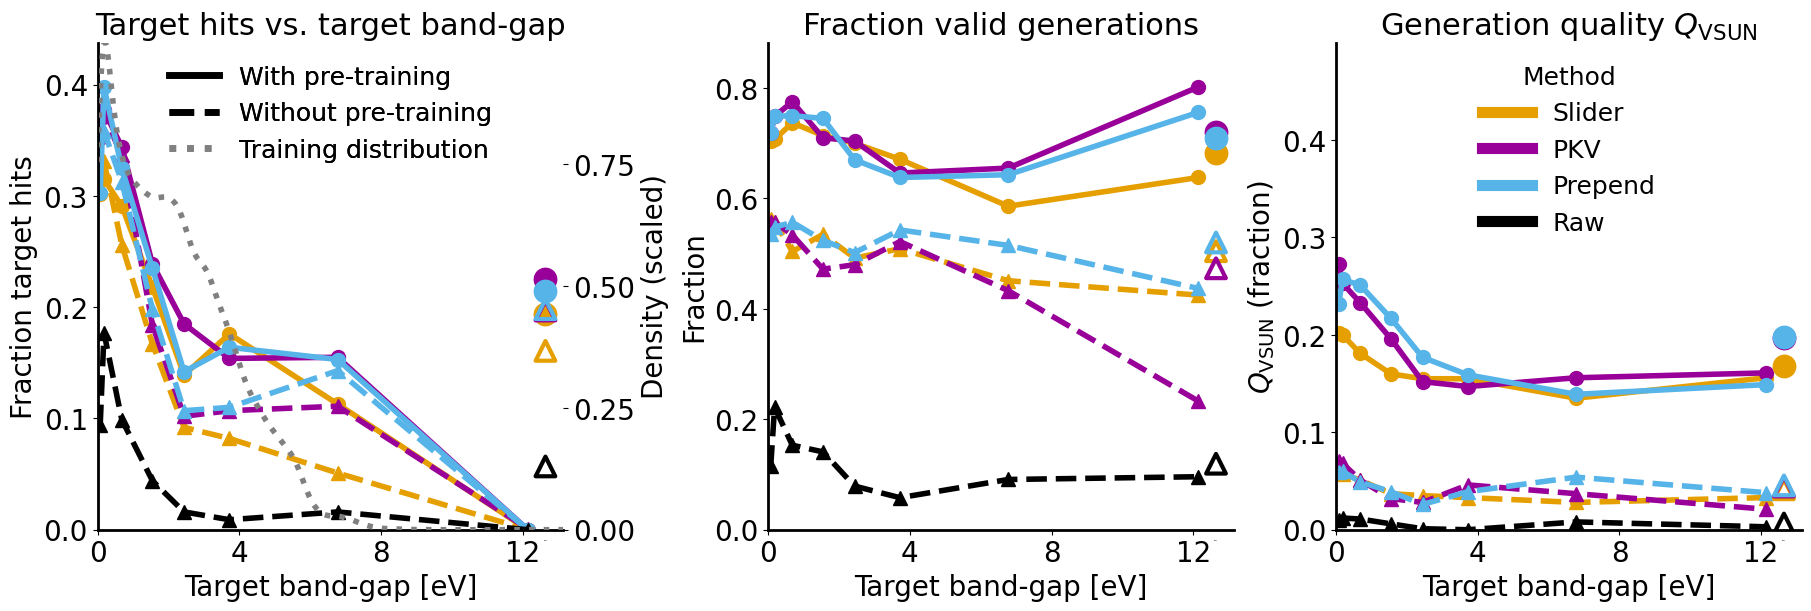

In [5]:
fig = make_conditional_performance_plot(
    dfs,
    train_df=train_df,
    target_bg_col="target_Bandgap (eV)",
    savepath=None,
    xlim=(0,12.5),
    ylim_q=(0,0.5),
    hit_tol_eV=0.5,
    ylim_hit=None,
    ylim_valid=None,
    label_fontsize=20,
    title_fontsize=22,
    ticks_fontsize=20,
    legend_fontsize=18,
    mean_fontsize=0,
    line_width=4,
    marker_size=10,
    scatter_size=200,
    scatter_lw=3.0,
    axes_thickness=2
)


In [30]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib.ticker import MaxNLocator
from brokenaxes import brokenaxes
from pathlib import Path

def load(path):
    with open(path) as f:
        d=json.load(f)
    return (np.array(d["training_steps"],float),
            np.array(d["training_losses"],float),
            np.array([]),
            np.array([])) 

def plot_losses(
    pretrained_model_losses, 
    finetuned_models_losses, 
    output_path, 
    window=5000, 
    ymax=0.85, 
    ymin=0.2,
    figsize=(12, 8),
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    line_width=2.5,
    # --- Arguments for axes width and tick count ---
    axes_linewidth=1.5,
    num_xticks=6,
    num_yticks=6
    ):
    
    # --- Color and Style mappings for clarity and consistency ---
    OKABE_ITO = {
        "Slider": "#E69F00",
        "PKV": "#990099",
        "Prepend": "#56B4E9",
        "Raw": "#000000"
    }
    LINE_STYLES = {
        "Raw": (0, (5, 2)),      # Dashed
        "Slider": (0, (3, 1, 1, 1)), # Densely dash-dotted
        "Prepend": ':',          # Dotted
        "PKV": '-.'             # Dash-dotted
    }


    p_steps,p_train,p_vsteps,p_vloss=load(pretrained_model_losses)
    p_max=p_steps.max()
    w=window

    fine=[]
    f_right=0
    labels=[]
    for idx,pth in enumerate(finetuned_models_losses,1):
        s,t,vs,vl=load(pth)
        s_shift=s+p_max
        vs_shift=vs+p_max
        fine.append((idx,s_shift,t,vs_shift,vl))
        f_right=max(f_right,s_shift.max())
        pth_lower = pth.lower()
        if 'slider' in pth_lower:
            labels.append('Slider')
        elif 'prepend' in pth_lower:
            labels.append('Prepend')
        elif 'pkv' in pth_lower:
            labels.append('PKV')
        elif 'raw' in pth_lower:
            labels.append('Raw')

    fig=plt.figure(figsize=figsize)
    bax=brokenaxes(
        xlims=((0,w),(p_max-w,f_right-15000)),
        hspace=0.2, tilt=90, d=0, fig=fig, wspace=0.2,
    )
    # bax.set_yscale("log")
    
    # --- Set tick locators to control the number of ticks ---
    # Fix: Access individual axes within brokenaxes object
    for ax in bax.axs:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=num_xticks))

    # --- Set axes/spine linewidth ---
    for ax in bax.axs:
        for spine in ax.spines.values():
            spine.set_linewidth(axes_linewidth)

    palette=plt.get_cmap("tab10").colors

    pre_mask_first=p_steps<=w
    pre_mask_last=p_steps>=p_max-w
    bax.plot(p_steps[pre_mask_first],p_train[pre_mask_first],
             color='gray',label="CrystaLLMv2 Base",linewidth=line_width)
    if p_vsteps.size:
        vmask=p_vsteps<=w
        bax.plot(p_vsteps[vmask],p_vloss[vmask],
                 color='gray',alpha=0.8,linewidth=line_width-0.5,linestyle="--",label="pretrain val")
    bax.plot(p_steps[pre_mask_last],p_train[pre_mask_last],color='gray',linewidth=line_width)
    if p_vsteps.size:
        vmask=p_vsteps>=p_max-w
        bax.plot(p_vsteps[vmask],p_vloss[vmask],
                 color='gray',alpha=0.8,linewidth=line_width-0.5,linestyle="--")


    for idx, (s_idx, s, t, vs, vl) in enumerate(fine):
        method_name = labels[s_idx-1]
        col = OKABE_ITO.get(method_name, palette[idx+1 % len(palette)])
        style = LINE_STYLES.get(method_name, '--') # Default to dashed if not found
        
        # print(f"finetune model {idx}: {s_idx}")
        bax.plot(
            s, t,
            color=col,
            linewidth=line_width,
            linestyle=style,
            label=f"Finetune Method: "+method_name,
            alpha=1.0,)
        if vs.size:
            bax.plot(
                vs, vl,
                color=col,
                linewidth=line_width-0.5,
                linestyle=style,
                alpha=0.7,
                label=f"Finetune Method: "+method_name+" val",
                )
            
    bax.set_ylim(ymin,ymax)
    bax.set_ylabel("LLM Train Loss", fontsize=label_fontsize)
    bax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
        
    # one centred xlabel
    fig.text(0.5, 0.08, "Trainer Step", ha="center", va="center", fontsize=label_fontsize)

    bax.grid(True, which='major', linestyle='--', linewidth=0.5)
    bax.legend(loc="upper right", frameon=False, fontsize=legend_fontsize)
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
    Path(output_path).parent.mkdir(parents=True,exist_ok=True)
    fig.savefig(output_path,dpi=300,bbox_inches="tight")
    plt.show()
    plt.close(fig)

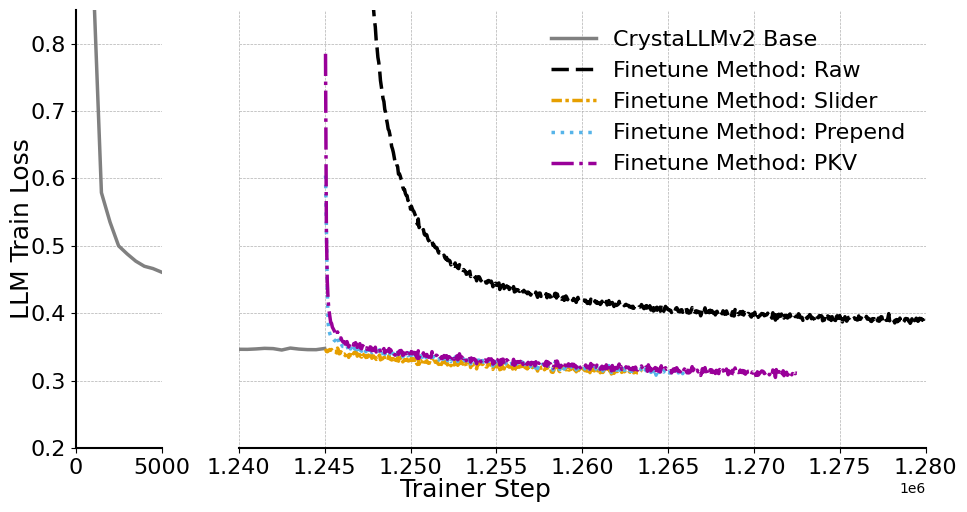

In [33]:
pretrained_model_losses = "model_ckpts/mpdb-small-base-lematerial/checkpoint-1245000/losses.json"
finetuned_models_losses = [
    "model_ckpts/mpdb_2prop_ft_raw/raw-v2/checkpoint-50000/losses.json",
    "model_ckpts/mpdb_2prop_ft/slider/checkpoint-18500/losses.json",
    "model_ckpts/mpdb_2prop_ft/prepend/checkpoint-21000/losses.json",
    "model_ckpts/mpdb_2prop_ft/PKV/checkpoint-27500/losses.json",
] 
output_path = "test.png"

plot_losses(
    pretrained_model_losses,
    finetuned_models_losses,
    output_path,
    window=5000,
    ymin=0.20,
    ymax=0.85,

    figsize=(10, 6),
    label_fontsize=18,
    ticks_fontsize=16,
    legend_fontsize=16,
    line_width=2.5,
    axes_linewidth=1.5,
    num_xticks=4,
    num_yticks=4
)




## Density

### 1. Dataset Size Study

In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import lines
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gs

OKABE_ITO = {"PKV": "#990099", "Slider": "#E69F00", "Prepend": "#56B4E9"}
SIZE_STYLE = {"full": "-", "100k": "--", "10k": "-.", "1k": ":"}
SIZE_MARK  = {"full": "o", "100k": "s", "10k": "^", "1k": "d"}


def _model(k: str) -> str:
    k = k.lower()
    if "pkv" in k:     return "PKV"
    if "slider" in k:  return "Slider"
    return "Prepend"

def _size(k: str) -> str:
    for s in ("100k", "10k", "1k"):
        if f"-{s}" in k: return s
    return "full"

def _subset(df: pd.DataFrame, tgt_col: str, tgt: float, gen_col: str):
    m = np.isclose(df[tgt_col], tgt, atol=1e-2) & df["is_valid"] & df[gen_col].notna()
    return pd.to_numeric(df.loc[m, gen_col], errors="coerce").dropna()

def _smooth_counts(vals: np.ndarray, xs: np.ndarray):
    kde = gaussian_kde(vals, bw_method="scott")
    return kde(xs) * len(vals)

def make_density_comparison_plot(
    dfs_dict: dict,
    train_df: pd.DataFrame,
    *,
    train_col="Density (g/cm^3)",
    target_col="target_Density (g/cm^3)",
    gen_col="gen_density (g/cm3)",
    targets=(1.2747, 15.30, 22.94),
    savepath=None,
    # --- Paper-ready style arguments ---
    figsize=(15, 6),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    line_width=2.5,
    scatter_size=100,
    marker_size=8,
    axes_linewidth=1.5,
    num_yticks=5,
    num_yticks_ref=3
):
    fig = plt.figure(figsize=figsize)
    gspec = gs.GridSpec(1, 3, figure=fig, wspace=0.1)
    axes = [fig.add_subplot(gspec[i]) for i in range(3)]

    ref_vals = pd.to_numeric(train_df[train_col], errors="coerce").dropna()
    xs_ref   = np.linspace(0, 30, 400)
    ref_kde  = gaussian_kde(ref_vals, bw_method="scott")(xs_ref)
    ref_kde /= ref_kde.max()

    global_max = 0.0
    
    scatter_offsets = {"PKV": -0.3, "Slider": 0, "Prepend": 0.3}

    for idx, (tgt, ax) in enumerate(zip(targets, axes)):
        ax_r = ax.twinx()
        ax_r.fill_between(xs_ref, 0, ref_kde, color="#888888", alpha=0.35)
        ax_r.set_ylim(0, 2)
        if idx == 2:
            ax_r.set_ylabel("Reference density", color="#666666", fontsize=label_fontsize)
            ax_r.tick_params(axis="y", colors="#666666", labelsize=ticks_fontsize)
        else:
            ax_r.tick_params(axis="y", labelright=False)
        ax_r.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks_ref, prune="upper"))
        ax_r.spines["right"].set_color("#666666")
        ax_r.spines["right"].set_linewidth(axes_linewidth)


        ax.axvline(tgt, color="black", ls=":", lw=line_width)

        min_icon_x = 0.0

        for key, df in dfs_dict.items():
            m = _model(key)
            s = _size(key)
            vals = _subset(df, target_col, tgt, gen_col)
            if vals.empty:
                continue
        
            ys = _smooth_counts(vals.values, xs_ref)
            ax.plot(xs_ref, ys, color=OKABE_ITO[m], ls=SIZE_STYLE[s], lw=line_width)

            count = len(vals)
            mean_x = float(np.mean(vals.values))
            offset = scatter_offsets.get(m, 0)
            
            face_color = OKABE_ITO[m]
            ax.scatter(
                mean_x + offset, count,
                marker=SIZE_MARK[s], s=scatter_size,
                edgecolor=face_color, 
                facecolor=face_color, 
                linewidth=line_width / 2,
                zorder=5,
            )

            min_icon_x = min(min_icon_x, mean_x)
            global_max = max(global_max, count, ys.max())

        right_lim = 25
        left_lim = min(0.0, min_icon_x - 1.0)
        ax.set_xlim(left_lim, right_lim)

        if idx == 0:
            ax.set_ylabel("Valid count", fontsize=label_fontsize)
        
        ax.set_xlabel("Density [g/cm³]", fontsize=label_fontsize)
        ax.set_title(f"Target Density: {tgt:.2f} [g/cm³]", fontsize=title_fontsize)
        ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="upper"))
        
        for side in ("right", "top"):
            ax.spines[side].set_visible(False)
        for side in ("left", "bottom"):
            ax.spines[side].set_linewidth(axes_linewidth)

    for ax in axes:
        ax.set_ylim(0, global_max * 1.10)
    for i in range(1, len(axes)):
        axes[i].sharey(axes[0])
        axes[i].tick_params(axis="y", labelleft=False)

    color_h = [lines.Line2D([], [], color=c, lw=line_width*1.5) for c in OKABE_ITO.values()]
    size_h  = [lines.Line2D([], [], color="black", lw=line_width, ls=ls) for ls in SIZE_STYLE.values()]
    marker_h = [lines.Line2D([], [], color="black", lw=0, marker=m, markersize=marker_size) for m in SIZE_MARK.values()]

    all_handles = color_h + marker_h + size_h
    model_labels = list(OKABE_ITO.keys())
    size_labels_markers = [f"{s} (marker)" for s in SIZE_MARK.keys()]
    size_labels_lines = [f"{s} (line)" for s in SIZE_STYLE.keys()]
    all_labels = model_labels + list(SIZE_MARK.keys()) + list(SIZE_STYLE.keys())

    fig.legend(all_handles, all_labels,
               loc="lower center", 
               bbox_to_anchor=(0.5, -0.4), 
               ncol=5, 
               frameon=False,
               fontsize=legend_fontsize)

    fig.tight_layout(rect=[0, 0.1, 1, 1])

    # === POST-PLOT METRICS ===
    metrics = []
    for tgt in targets:
        for key, df in dfs_dict.items():
            m = _model(key)
            s = _size(key)
            vals = _subset(df, target_col, tgt, gen_col)
            if vals.empty:
                continue
            count = len(vals)
            mean_x= float(np.mean(vals.values))
            mae    = np.mean(np.abs(vals.values - tgt))
            std    = np.std(vals.values, ddof=0)
            metrics.append({"method":m,"size":s,"target":tgt,
                            "count":count,"mean":mean_x,"mae":mae,"std":std})

    from scipy.stats import pearsonr, ttest_rel
    met_df = pd.DataFrame(metrics)
    
    # Clean the data just in case
    if 'size' in met_df.columns:
        met_df['size'] = met_df['size'].astype(str).str.strip()
    
    size_map = {"full":len(train_df),"100k":1e5,"10k":1e4,"1k":1e3}
    met_df["size_numeric"] = met_df["size"].map(size_map)

    for method in met_df.method.unique():
        sub = met_df[met_df.method==method]
        if len(sub)>=2:
            r,_ = pearsonr(sub["count"], sub["size_numeric"])
            print(f"{method}: Pearson r (valid count vs size) = {r:.3f}")

    for method in met_df.method.unique():
        vals = met_df[met_df.method==method]["mae"].values
        mean_mae = vals.mean()
        sem_mae  = vals.std(ddof=1)/np.sqrt(len(vals)) if len(vals)>1 else np.nan
        print(f"{method}: Avg MAE = {mean_mae:.3f} ± {sem_mae:.3f}")

    for method in met_df.method.unique():
        vals = met_df[met_df.method==method]["std"].values
        m = vals.mean()
        s = vals.std(ddof=1)/np.sqrt(len(vals)) if len(vals)>1 else np.nan
        print(f"{method}: Avg std = {m:.3f} ± {s:.3f}")


    df_1k = met_df[met_df['size'] == '1k']
    
    for method in ['Slider', 'PKV', 'Prepend']:
        # Further filter by method
        method_counts = df_1k[df_1k['method'] == method]['count']
        
        if not method_counts.empty:
            mean_count = method_counts.mean()
            # Calculate Standard Error of the Mean (SEM)
            sem_count = method_counts.std(ddof=1) / np.sqrt(len(method_counts)) if len(method_counts) > 1 else 0.0
            print(f"{method} (1k): Avg valid count = {mean_count:.1f} ± {sem_count:.1f}")
        else:
            print(f"{method} (1k): No data found.")

    for method in met_df.method.unique():
        for size in ("1k","10k","100k","full"):
            sub = met_df[(met_df.method==method)&(met_df.size==size)]
            if not sub.empty:
                vals = sub['mae'].values
                m = vals.mean()
                s = vals.std(ddof=1)/np.sqrt(len(vals)) if len(vals)>1 else np.nan
                print(f"{method} ({size}): Avg MAE = {m:.3f} ± {s:.3f}")

    df_wide = met_df.pivot_table(index=["target","size"], columns="method", values="mae").dropna()
    if {"Slider","PKV"}.issubset(df_wide.columns):
        t,p = ttest_rel(df_wide["Slider"], df_wide["PKV"])
        print(f"t-test Slider vs PKV MAE: t={t:.3f}, p={p:.3f}")
    if {"Prepend","PKV"}.issubset(df_wide.columns):
        t,p = ttest_rel(df_wide["Prepend"], df_wide["PKV"])
        print(f"t-test Prepend vs PKV MAE: t={t:.3f}, p={p:.3f}")

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches='tight')

    return fig

In [14]:
import pandas as pd
dfs_2 = {
    "mgen_ft-den-1k_slider": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-1k-slider_post.parquet"),
    "mgen_ft-den-1k_PKV": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-1k-PKV_post.parquet"),
    "mgen_ft-den-1k_prepend": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-1k-prepend_post.parquet"),
    "mgen_ft-den-10k_slider": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-10k-slider_post.parquet"),
    "mgen_ft-den-10k_PKV": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-10k-PKV_post.parquet"),
    "mgen_ft-den-10k_prepend": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-10k-prepend_post.parquet"),
    "mgen_ft-den-100k_slider": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-100k-slider_post.parquet"),
    "mgen_ft-den-100k_PKV": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-100k-PKV_post.parquet"),
    "mgen_ft-den-100k_prepend": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-100k-prepend_post.parquet"),
    "mgen_ft-den-full_prepend" : pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-prepend_post.parquet"),
    "mgen_ft-den-full_PKV" : pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-PKV_post.parquet"),
    "mgen_ft-den-full_slider" : pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/dataset_size_study/mgen_ft-den-slider-10T15K_post.parquet"),
}
# Load the dataset for training background
from datasets import load_dataset

ds = load_dataset('c-bone/mattergen_den_ehull', split='train')
train_df = ds.to_pandas()

/tmp/ipykernel_2256981/987636952.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])


Slider: Pearson r (valid count vs size) = 0.199
PKV: Pearson r (valid count vs size) = 0.294
Prepend: Pearson r (valid count vs size) = 0.336
Slider: Avg MAE = 6.351 ± 1.660
PKV: Avg MAE = 5.236 ± 1.506
Prepend: Avg MAE = 6.193 ± 1.681
Slider: Avg std = 1.956 ± 0.188
PKV: Avg std = 1.786 ± 0.179
Prepend: Avg std = 1.991 ± 0.214
Slider (1k): Avg valid count = 880.7 ± 15.6
PKV (1k): Avg valid count = 818.0 ± 13.1
Prepend (1k): Avg valid count = 729.7 ± 12.1
t-test Slider vs PKV MAE: t=4.123, p=0.002
t-test Prepend vs PKV MAE: t=3.515, p=0.005


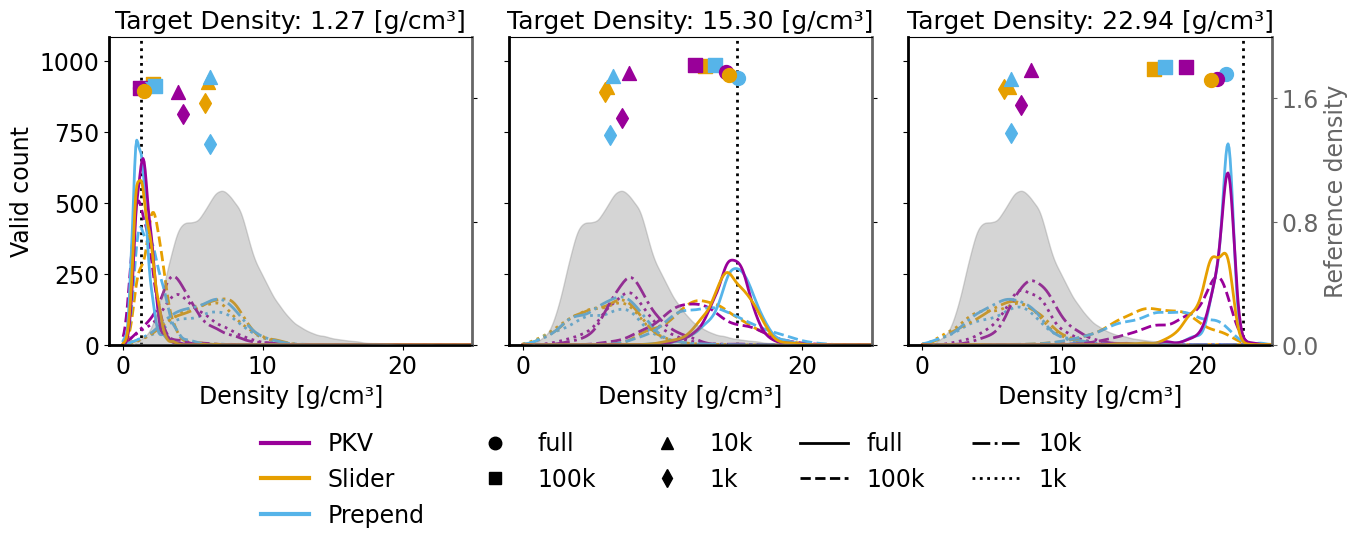

In [15]:
fig = make_density_comparison_plot(
    dfs_2,
    train_df=train_df,
    # savepath="dataset_size_study.png",
    figsize=(15, 4),
    title_fontsize=18,
    label_fontsize=17,
    ticks_fontsize=17,
    legend_fontsize=17,
    line_width=2.0,
    scatter_size=100,
    marker_size=9,
    axes_linewidth=2,
    num_yticks=5,
    num_yticks_ref=3
)

### 2. SiO2 Study

In [26]:
df = pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/SiO2/mgen_PKV-SiO2-den-ehull-10T15K_post-s.parquet")
df

,Material ID,Prompt,Generated CIF,Condition Vector,is_valid,composition,is_unique,is_novel,target_Density (g/cm^3),target_energy_above_hull,gen_density (g/cm3),ehull_mace,is_stable_orb,ehull_mace_mp
0,Generated_1,<bos>\ndata_[Si1O2]\n,\ndata_Si1O2\n_symmetry_space_group_name_H-M P...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN
1,Generated_2,<bos>\ndata_[Si1O2]\n,\ndata_Si1O2\n_symmetry_space_group_name_H-M P...,"0.0588, 0.0000",True,Si1 O2,False,False,1.499047,0.0,3.155799,1.523099,False,1.056434
2,Generated_3,<bos>\ndata_[Si1O2]\n,\ndata_Si1O2\n_symmetry_space_group_name_H-M P...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN
3,Generated_4,<bos>\ndata_[Si1O2]\n,\ndata_Si1O2\n_symmetry_space_group_name_H-M P...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN
4,Generated_5,<bos>\ndata_[Si1O2]\n,\ndata_Si1O2\n_symmetry_space_group_name_H-M P...,"0.0588, 0.0000",True,Si1 O2,False,False,1.499047,0.0,3.436796,0.824245,False,0.357581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101245,Generated_53996,<bos>\ndata_[Si20O40]\n,\ndata_Si20O40\n_symmetry_space_group_name_H-M...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN
101246,Generated_53997,<bos>\ndata_[Si20O40]\n,\ndata_Si20O40\n_symmetry_space_group_name_H-M...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN
101247,Generated_53998,<bos>\ndata_[Si20O40]\n,\ndata_Si20O40\n_symmetry_space_group_name_H-M...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN
101248,Generated_53999,<bos>\ndata_[Si20O40]\n,\ndata_Si20O40\n_symmetry_space_group_name_H-M...,"0.0588, 0.0000",False,None,False,False,1.499047,0.0,NaN,NaN,False,NaN


In [34]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import lines
from matplotlib.ticker import MaxNLocator

OKABE_ITO = {"PKV": "#990099", "Unconditional (Slider)": "#E69F00"}
SIZE_STYLE = {"full": "-"}
SIZE_MARK  = {"full": "o"}

def _model(k: str) -> str:
    return "PKV" if "pkv" in k.lower() else "Unconditional (Slider)"

def _subset(df: pd.DataFrame, tgt: float, gen_col: str):
    m = df["is_valid"] & df[gen_col].notna()
    return pd.to_numeric(df.loc[m, gen_col], errors="coerce").dropna()

def _smooth_counts(vals: np.ndarray, xs: np.ndarray):
    kde  = gaussian_kde(vals, bw_method="scott")
    return kde(xs) * len(vals)

def make_sio2_density_plot(
    dfs_dict: dict,
    train_df: pd.DataFrame,
    *,
    train_col="Density (g/cm^3)",
    gen_col="gen_density (g/cm3)",
    target_density=1.5,
    savepath=None,
    # --- Paper-ready style arguments ---
    figsize=(6, 6),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    annot_fontsize=12,
    line_width=2.5,
    scatter_size=100,
    marker_size=8,
    axes_linewidth=1.5,
    num_yticks=5,
    num_yticks_ref=4
):
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax_r = ax.twinx()

    # Reference density
    train_df_sio2 = train_df
    ref_vals = pd.to_numeric(train_df_sio2[train_col], errors="coerce").dropna().values
    xs_ref   = np.linspace(0, 25, 400)
    ref_kde  = gaussian_kde(ref_vals, bw_method="scott")(xs_ref)
    ref_kde /= ref_kde.max()
    ax_r.fill_between(xs_ref, 0, ref_kde, color="#888888", alpha=0.35)
    ax_r.set_ylim(0, 2.0)
    ax_r.set_ylabel("Reference density", color="#666666", fontsize=label_fontsize)
    ax_r.tick_params(axis="y", colors="#666666", labelsize=ticks_fontsize)
    ax_r.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks_ref, prune="upper"))
    ax_r.spines["right"].set_color("#666666")
    ax_r.spines["right"].set_linewidth(axes_linewidth)


    # Target line
    ax.axvline(target_density, color="black", ls=":", lw=line_width)

    global_max = 0.0
    
    # Jitter for scatter markers to prevent overlap
    scatter_offsets = {"PKV": -0.05, "Unconditional (Slider)": 0.05}
    
    # Plot each model’s KDE and summary icon at the MEAN
    for key, df in dfs_dict.items():
        m   = _model(key)
        s   = "full"
        vals = _subset(df, target_density, gen_col)
        if vals.empty:
            continue

        ys = _smooth_counts(vals.values, xs_ref)
        ax.plot(xs_ref, ys, color=OKABE_ITO[m], ls=SIZE_STYLE[s], lw=line_width)

        # summary icon: x = MEAN of generated, y = valid count
        mean_x = float(np.mean(vals.values))
        count  = len(vals)
        offset = scatter_offsets.get(m, 0)
        
        ax.scatter(
            mean_x + offset, count,
            marker=SIZE_MARK[s],
            s=scatter_size,
            edgecolor=OKABE_ITO[m],
            facecolor=OKABE_ITO[m],
            zorder=5,
        )

        # annotate MAE ± SEM
        mae = np.mean(np.abs(vals.values - target_density))
        sem = np.std(vals.values, ddof=1) / np.sqrt(count)
        ax.annotate(
            f"MAE={mae:.3f}±{sem:.3f}",
            (mean_x + offset, count),
            textcoords="offset points",
            xytext=(10, 0),
            ha="left",
            va="center",
            fontsize=annot_fontsize
        )

        global_max = max(global_max, count, ys.max())

    # Axes formatting
    ax.set_xlim(0, 5)
    ax.set_ylim(0, global_max * 1.10)
    ax.set_xlabel("Density [g/cm³]", fontsize=label_fontsize)
    ax.set_ylabel("Valid count", fontsize=label_fontsize)
    ax.set_title(f"SiO2 Target Density : 1.5 [g/cm³]", fontsize=title_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="upper"))
    
    for side in ("right", "top"):
        ax.spines[side].set_visible(False)
    for side in ("left", "bottom"):
        ax.spines[side].set_linewidth(axes_linewidth)


    # Legend
    color_h = [lines.Line2D([], [], color=c, lw=line_width*1.5) for c in OKABE_ITO.values()]
    mark_h  = [lines.Line2D([], [], color="black", lw=0, marker="o", markersize=marker_size)]
    ax.legend(
        color_h + mark_h,
        list(OKABE_ITO.keys()) + ["x=mean(gen), y=count"],
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=2,
        fontsize=legend_fontsize
    )

    if savepath:
        fig.savefig(savepath, dpi=500, bbox_inches='tight')

    # Print count of sub-threshold densities
    for key, df in dfs_dict.items():
        m = _model(key)
        vals = _subset(df, target_density, gen_col)
        ct = len(vals[vals <= target_density])
        print(f"{m} ≤ {target_density:.2f} g/cm³: {ct}")

    return fig

In [7]:
import pandas as pd
dfs_3 = {
    "mgen_PKV-SiO2-den-ehull-10T15K": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/SiO2/mgen_PKV-SiO2-den-ehull-10T15K_post-s.parquet"),
    "mgen_SiO2-uncond-10T15K_post": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/SiO2/mgen_PKV-SiO2-den-ehull-uncond-10T15K_post-s.parquet"),
}
# Load the dataset for training background
from datasets import load_dataset

ds = load_dataset('c-bone/mattergen_den_ehull', split='train')
train_df = ds.to_pandas()

PKV ≤ 1.95 g/cm³: 10122
Unconditional (Slider) ≤ 1.95 g/cm³: 5757


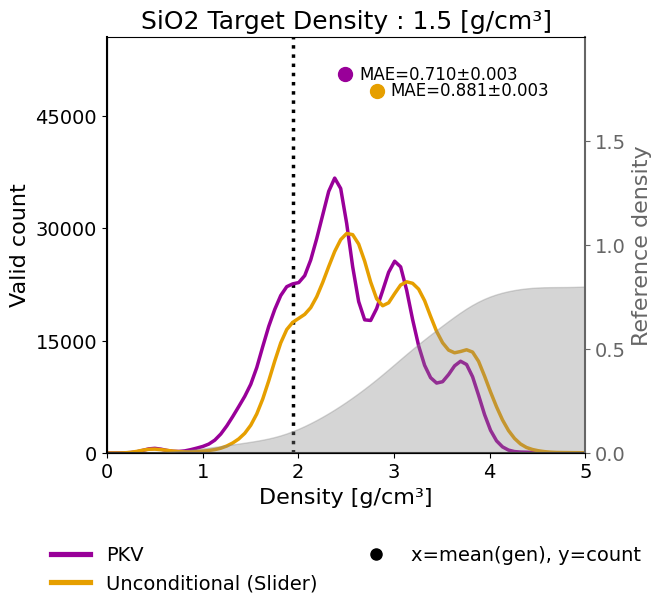

In [35]:
plot = make_sio2_density_plot(
    dfs_dict=dfs_3,
    train_df=train_df,
    target_density=1.95,
    savepath=None,
    figsize=(6.5, 6),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    annot_fontsize=12,
    line_width=2.5,
    scatter_size=100,
    marker_size=8,
    axes_linewidth=1.5,
    num_yticks=5,
    num_yticks_ref=4
)

## Bandgap

### 1. Full train set conditional gen

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import lines
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gs

OKABE_ITO = {"PKV": "#990099"}
SIZE_STYLE = {"full": "-"}
SIZE_MARK  = {"full": "o"}

def _subset_bg(df: pd.DataFrame, tgt: float, gen_col: str):
    m = np.isclose(df["target_ALIGNN_BG"], tgt, atol=1e-2) \
        & df["is_valid"] & df[gen_col].notna()
    return pd.to_numeric(df.loc[m, gen_col], errors="coerce").dropna()

def _counts_curve(vals: np.ndarray, xs: np.ndarray, bw: float):
    kde  = gaussian_kde(vals, bw_method="scott")
    dens = kde(xs)
    return dens * len(vals) * bw

def make_bandgap_comparison_plot(
    dfs_dict: dict,
    train_df: pd.DataFrame,
    *,
    train_col="ALIGNN_BG",
    gen_col="ALIGNN_bg (eV)",
    targets=(0.06, 2.42, 6.69),
    bin_width=0.20,
    savepath=None,
    # --- Paper-ready style arguments ---
    figsize=(15, 5),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    line_width=2.5,
    scatter_size=100,
    marker_size=8,
    axes_linewidth=1.5,
    num_yticks=5,
    num_yticks_ref=4
):
    if train_col not in train_df.columns:
        raise ValueError(f"Train DataFrame must contain '{train_col}'")

    fig = plt.figure(figsize=figsize)
    gspec = gs.GridSpec(1, 3, figure=fig, wspace=0.1)
    axes  = [fig.add_subplot(gspec[i]) for i in range(3)]

    xs_ref = np.arange(0, 10 + bin_width/4, bin_width/4)
    ref_vals = pd.to_numeric(train_df[train_col], errors="coerce").dropna().values
    ref_kde = gaussian_kde(ref_vals, bw_method="scott")(xs_ref)
    ref_kde /= ref_kde.max()

    curve_max, count_max = 0.0, 0
    curves, maes, counts = [], [], []

    df_gen = next(iter(dfs_dict.values()))

    for tgt in targets:
        vals = _subset_bg(df_gen, tgt, gen_col)
        if vals.empty:
            curves.append(np.zeros_like(xs_ref))
            maes.append(np.nan)
            counts.append(0)
            continue
        ys = _counts_curve(vals.values, xs_ref, bin_width)
        curves.append(ys)
        counts.append(len(vals))
        maes.append(float(np.mean(np.abs(vals.values - tgt))))
        curve_max = max(curve_max, ys.max())
        count_max = max(count_max, len(vals))
        print(f"Target {tgt:.2f} eV: {len(vals)} valid samples")

    for idx, (tgt, ax, ys, mae, count) in enumerate(
            zip(targets, axes, curves, maes, counts)
        ):
        ax_r = ax.twinx()
        ax_r.fill_between(xs_ref, 0, ref_kde, color="#888888", alpha=0.8)
        ax_r.set_ylim(0, 2.0)
        if idx == 2:
            ax_r.set_ylabel("Reference density", color="#666666", fontsize=label_fontsize)
            ax_r.tick_params(axis="y", colors="#666666", labelsize=ticks_fontsize)
        else:
            ax_r.tick_params(axis="y", labelright=False)
        ax_r.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks_ref, prune="upper"))
        ax_r.spines["right"].set_color("#666666")
        ax_r.spines["right"].set_linewidth(axes_linewidth)


        ax.axvline(tgt, color="black", ls=":", lw=line_width)
        ax.plot(xs_ref, ys, color=OKABE_ITO["PKV"], ls=SIZE_STYLE["full"], lw=line_width)

        if not np.isnan(mae):
            vals = _subset_bg(df_gen, tgt, gen_col)
            if not vals.empty:
                x_icon = np.mean(vals.values)
                ax.scatter(
                    x_icon, count,
                    marker=SIZE_MARK["full"],
                    s=scatter_size, facecolor=OKABE_ITO["PKV"], edgecolor=OKABE_ITO["PKV"],
                    zorder=5
                )

        ax.set_xlim(0, 9)

        if idx == 0:
            ax.set_ylabel("Valid count", fontsize=label_fontsize)
        
        ax.set_xlabel("Bandgap [eV]", fontsize=label_fontsize)
        ax.set_title(f"Target Bandgap: {tgt:.2f} [eV]", fontsize=title_fontsize)
        ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="upper"))
        
        for s in ("right", "top"):
            ax.spines[s].set_visible(False)
        for s in ("left", "bottom"):
            ax.spines[s].set_linewidth(axes_linewidth)


    # --- Set and share axes limits correctly ---
    for ax in axes:
        ax.set_ylim(0, max(curve_max, count_max) * 1.1)
    for i in range(1, len(axes)):
        axes[i].sharey(axes[0])
        axes[i].sharex(axes[0])
        axes[i].tick_params(axis="y", labelleft=False)


    leg_lines = [
        lines.Line2D([], [], color="#990099", lw=line_width*1.5),
        lines.Line2D([], [], color="#990099", marker="o", lw=0, markersize=marker_size),
    ]
    axes[1].legend(leg_lines, ["PKV distribution", "x=mean(gen), y=count"],
                   frameon=False, loc="upper center",
                   bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=legend_fontsize)

    fig.tight_layout(rect=[0, 0.05, 1, 1])


    if savepath:
        fig.savefig(savepath, dpi=500, bbox_inches='tight')

    # === PRINT MAE SUMMARY ===
    maes_arr = np.array(maes)
    for tgt, mae_val in zip(targets, maes_arr):
        print(f"Target {tgt:.2f} eV: MAE = {mae_val:.3f}")
        vals = _subset_bg(df_gen, tgt, gen_col)
        if not vals.empty:
            std_dev = np.std(vals.values, ddof=1)
            print(f"Target {tgt:.2f} eV: Std Dev of generated bandgap = {std_dev:.3f} eV")

    sem_targets = np.std(maes_arr, ddof=1) / np.sqrt(len(maes_arr))
    print(f"Mean MAE = {np.mean(maes_arr):.3f} ± {sem_targets:.3f} (SEM)")

    maes_train = []
    for tgt in targets:
        diffs = np.abs(ref_vals - tgt)
        m = diffs.mean()
        s = diffs.std(ddof=1) / np.sqrt(len(diffs))
        maes_train.append(m)
        print(f"Train vs {tgt:.2f} eV: MAE = {m:.3f} ± {s:.3f} (SEM)")
        
    sem_train = np.std(maes_train, ddof=1) / np.sqrt(len(maes_train))
    print(f"Train dist mean MAE = {np.mean(maes_train):.3f} ± {sem_train:.3f} (SEM)")

    # print x and y of each icon


    return fig

In [13]:
import pandas as pd
dfs_4 = {
    "mgen_ft-bg-PKV": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/mgen_bandgap/mgen_ft-bg-PKV_post.parquet"),
}
# Load the dataset for training background
from datasets import load_dataset

ds_bg = load_dataset('c-bone/mattergen_bg_ehull', split='train')
train_df_bg = ds_bg.to_pandas()

Target 0.06 eV: 949 valid samples
Target 2.42 eV: 953 valid samples
Target 6.69 eV: 940 valid samples
Target 0.06 eV: MAE = 0.118
Target 0.06 eV: Std Dev of generated bandgap = 0.276 eV
Target 2.42 eV: MAE = 0.625
Target 2.42 eV: Std Dev of generated bandgap = 0.847 eV
Target 6.69 eV: MAE = 0.882
Target 6.69 eV: Std Dev of generated bandgap = 1.312 eV
Mean MAE = 0.542 ± 0.224 (SEM)
Train vs 0.06 eV: MAE = 0.639 ± 0.002 (SEM)
Train vs 2.42 eV: MAE = 1.983 ± 0.001 (SEM)
Train vs 6.69 eV: MAE = 6.045 ± 0.002 (SEM)
Train dist mean MAE = 2.889 ± 1.625 (SEM)


/tmp/ipykernel_2081622/3118181295.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 1])


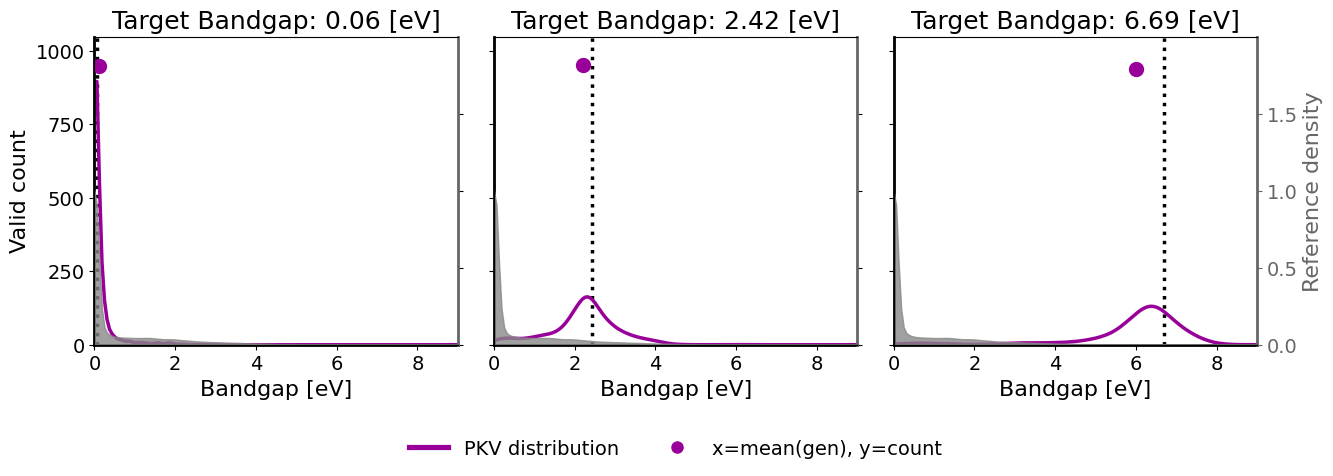

In [14]:
bg_plot = make_bandgap_comparison_plot(
    dfs_dict=dfs_4,
    train_df=train_df_bg,
    targets=(0.06, 2.42, 6.69),
    savepath=None,
    bin_width=0.25,
    figsize=(15, 4),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    line_width=2.5,
    scatter_size=100,
    marker_size=8,
    axes_linewidth=2.0,
    num_yticks=5,
    num_yticks_ref=4
)

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import lines
from matplotlib.ticker import MaxNLocator

def make_tio2_bandgap_plot(
    dfs_dict: dict,
    train_df: pd.DataFrame,
    *,
    train_col="ALIGNN_BG",
    gen_col="ALIGNN_bg (eV)",
    targets=(1.5, 4.5),
    bin_width=0.20,
    savepath=None,
    figsize=(8, 6),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    line_width=2.5,
    scatter_size=100,
    axes_linewidth=1.5,
    num_yticks=5,
    num_yticks_ref=4
):
    # Validate
    if train_col not in train_df.columns:
        raise ValueError(f"Train DataFrame must contain '{train_col}'")

    # Styles for the two targets
    styles = {
        targets[0]: {"color": "#990099", "marker": "o", "label": f"{targets[0]:.2f} eV"},
        targets[1]: {"color": "#550055", "marker": "s", "label": f"{targets[1]:.2f} eV"},
    }

    # Figure and axes
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax_r = ax.twinx()

    # Reference KDE
    xs_ref = np.arange(0, 10 + bin_width/4, bin_width/4)
    ref_vals = pd.to_numeric(train_df[train_col], errors="coerce").dropna().values
    ref_kde  = gaussian_kde(ref_vals, bw_method="scott")(xs_ref)
    ref_kde /= ref_kde.max()
    ax_r.fill_between(xs_ref, 0, ref_kde, color="#888888", alpha=0.35)
    ax_r.set_ylim(0, 2.0)
    ax_r.set_ylabel("Reference density", color="#666666", fontsize=label_fontsize)
    ax_r.tick_params(axis="y", colors="#666666", labelsize=ticks_fontsize)
    ax_r.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks_ref, prune="upper"))
    ax_r.spines["right"].set_color("#666666")
    ax_r.spines["right"].set_linewidth(axes_linewidth)


    # Target vertical lines
    for tgt in targets:
        ax.axvline(tgt, color="black", ls=":", lw=line_width)

    # Plot each target’s KDE and summary icon
    df_gen = next(iter(dfs_dict.values()))
    global_max = 0
    min_icon_x  = np.inf

    for tgt in targets:
        # extract valid generated values near target
        mask = (
            np.isclose(df_gen["target_ALIGNN_BG"], tgt, atol=1e-2)
            & df_gen["is_valid"]
            & df_gen[gen_col].notna()
        )
        vals = pd.to_numeric(df_gen.loc[mask, gen_col], errors="coerce").dropna()
        if vals.empty:
            continue

        # Smooth counts curve
        kde = gaussian_kde(vals.values, bw_method="scott")
        ys  = kde(xs_ref) * len(vals) * bin_width
        style = styles[tgt]
        ax.plot(xs_ref, ys, color=style["color"], lw=line_width, label=f"Target: {style['label']}")

        # Summary icon at mean
        mean_x = float(vals.mean())
        cnt    = len(vals)
        ax.scatter(
            mean_x, cnt,
            marker=style["marker"], s=scatter_size,
            edgecolor=style["color"], facecolor=style["color"], zorder=5
        )

        # Track limits
        global_max = max(global_max, cnt, ys.max())
        min_icon_x = min(min_icon_x, mean_x)

    # Axes formatting
    left_lim = min(0.0, min_icon_x - 0.5)
    ax.set_xlim(left_lim, 6)
    ax.set_ylim(0, global_max * 1.10)
    ax.set_xlabel("Bandgap [eV]", fontsize=label_fontsize)
    ax.set_ylabel("Valid count", fontsize=label_fontsize)
    ax.set_title("TiO₂ Target-conditioned Generation", fontsize=title_fontsize)

    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="upper"))
    
    for side in ("right", "top"):
        ax.spines[side].set_visible(False)
    for side in ("left", "bottom"):
        ax.spines[side].set_linewidth(axes_linewidth)


    # Legend: combine curve and marker entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(
        by_label.values(), by_label.keys(),
        frameon=False, loc="upper center", ncol=2, fontsize=legend_fontsize
    )

    if savepath:
        fig.savefig(savepath, dpi=500, bbox_inches='tight')

    # Print mean for each target
    for tgt in targets:
        mask = np.isclose(df_gen["target_ALIGNN_BG"], tgt, atol=1e-2) & df_gen["is_valid"]
        vals = pd.to_numeric(df_gen.loc[mask, gen_col], errors="coerce").dropna()
        if not vals.empty:
            mean_val = vals.mean()
            print(f"Mean for target {tgt:.2f} eV: {mean_val:.3f} eV")
            # and print standard dev
            std_val = vals.std(ddof=0)
            print(f"Standard deviation for target {tgt:.2f} eV: {std_val:.3f} eV")


    for tgt in targets:
        # select only runs conditioned on this tgt
        mask_tgt   = np.isclose(df_gen["target_ALIGNN_BG"], tgt, atol=1e-2)
        mask_valid = mask_tgt & df_gen["is_valid"] & df_gen[gen_col].notna()
        vals_tgt   = pd.to_numeric(df_gen.loc[mask_valid, gen_col], errors="coerce").dropna()
        if vals_tgt.empty:
            print(f"No valid generations for target {tgt:.2f} eV")
            continue

        in_range = ((vals_tgt >= 1.0) & (vals_tgt <= 1.7)).sum()
        above_2p5 = (vals_tgt > 2.5).sum()
        print(
            f"Conditioned on {tgt:.2f} eV → "
            f"{in_range} in [1.0, 1.7] eV, {above_2p5} > 2.5 eV"
        )
    return fig

In [5]:
import pandas as pd
dfs_5 = {
    "mgen_PKV-TiO2-10T15K_post": pd.read_parquet("_utils/_evaluation_conditional/evaluation_files/TiO2/mgen_PKV-TiO2-10T15K_post-s.parquet"),
}
# Load the dataset for training background
from datasets import load_dataset

ds_bg = load_dataset('c-bone/mattergen_bg_ehull', split='train')
train_df_bg = ds_bg.to_pandas()

Mean for target 1.50 eV: 1.140 eV
Standard deviation for target 1.50 eV: 1.004 eV
Mean for target 4.50 eV: 1.151 eV
Standard deviation for target 4.50 eV: 1.005 eV
Conditioned on 1.50 eV → 4084 in [1.0, 1.7] eV, 3066 > 2.5 eV
Conditioned on 4.50 eV → 3836 in [1.0, 1.7] eV, 3018 > 2.5 eV


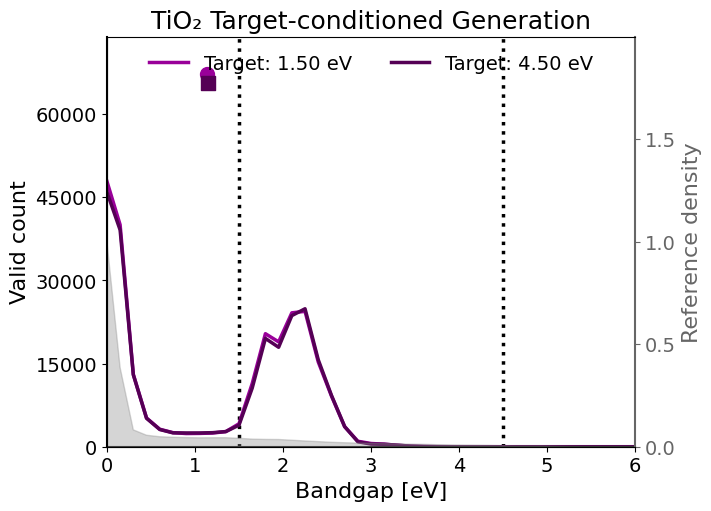

In [10]:
tio2_plot = make_tio2_bandgap_plot(
    dfs_dict=dfs_5,
    train_df=train_df_bg,
    targets=(1.5, 4.5),
    savepath=None,
    bin_width=0.6,
    figsize=(7, 5),
    title_fontsize=18,
    label_fontsize=16,
    ticks_fontsize=14,
    legend_fontsize=14,
    line_width=2.5,
    scatter_size=100,
    axes_linewidth=1.5,
    num_yticks=5,
    num_yticks_ref=4
)

## XRD

### 1. COD

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_true_vs_gen(
    df,
    *,
    savepath=None,
    # --- Paper-ready style arguments ---
    figsize=(12, 12),
    title_fontsize=20,
    label_fontsize=18,
    ticks_fontsize=16,
    legend_fontsize=16,
    annot_fontsize=16,
    scatter_size=30,
    scatter_edge_width=0.5,
    alpha_matched=0.9,
    alpha_unmatched=0.5,
    diag_line_width=1.0,
    axes_linewidth=1.0
):
    
    props = [
        ("True a", "Gen a",  "(a) Lattice const. (x)", "Target a [Å]",  "Pred. a [Å]"),
        ("True b", "Gen b",  "(b) Lattice const. (y)", "Target b [Å]",  "Pred. b [Å]"),
        ("True c", "Gen c",  "(c) Lattice const. (z)", "Target c [Å]",  "Pred. c [Å]"),
        ("True volume", "Gen volume", "(d) Volume",       "Target vol. [Å³]", "Pred. vol. [Å³]")
    ]

    # Define marker mapping for system types
    system_markers = {
        2: 'x',     # Binary - X
        3: '^',     # Ternary - triangle
        4: 's',     # Quaternary - square
        5: 'h',     # 5-system - hexagon
        6: 'o'      # 6-system - circle
    }
    
    system_names = {
        2: 'Binary',
        3: 'Ternary', 
        4: 'Quaternary',
        5: 'Quinary',
        6: 'Senary'
    }

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    # Create color masks based on RMS-d values
    rms_valid_mask = df['RMS-d'].notna()
    rms_invalid_mask = df['RMS-d'].isna()
    
    # amount of rows with 'NaNs or None' in "RMS-d" column
    invalid_rows = df[df['RMS-d'].isna()]
    print(f"Number of rows with None values: {len(invalid_rows)}")
    percent_valid = (len(df) - len(invalid_rows)) / len(df) * 100
    print(f"Percentage of matches: {percent_valid:.2f}%")

    # Print header for metrics table
    print("\n" + "="*80)
    print(f"{'Property':<15} {'Subset':<15} {'R²':<8} {'MAE':<8} {'σ':<8} {'N':<8}")
    print("="*80)

    for ax, (t_key, g_key, title, xlab, ylab) in zip(axes, props):
        x = df[t_key].to_numpy(dtype=float)
        y = df[g_key].to_numpy(dtype=float)

        # Create masks for valid data points (not NaN)
        valid_data_mask = ~np.isnan(x) & ~np.isnan(y)
        
        # Also filter out points with invalid system types
        valid_system_mask = df['System'].notna() & df['System'].isin(system_markers.keys())
        
        # Combine all validity masks
        combined_valid_mask = valid_data_mask & valid_system_mask
        
        # Plot points for each combination of color and system type
        plotted_colors = set()
        plotted_systems = set()
        
        for system_type, marker in system_markers.items():
            system_mask = (df['System'] == system_type) & combined_valid_mask
            
            if system_mask.any():
                plotted_systems.add(system_type)
                
                # Green points (RMS-d valid)
                green_system_mask = system_mask & rms_valid_mask
                if green_system_mask.any():
                    ax.scatter(x[green_system_mask], y[green_system_mask], 
                             s=scatter_size, alpha=alpha_matched, 
                             color="green", marker=marker, edgecolor="black", 
                             linewidth=scatter_edge_width)
                    plotted_colors.add('green')
                
                # Orange points (RMS-d invalid)  
                orange_system_mask = system_mask & rms_invalid_mask
                if orange_system_mask.any():
                    ax.scatter(x[orange_system_mask], y[orange_system_mask], 
                             s=scatter_size, alpha=alpha_unmatched,
                             color="orange", marker=marker, edgecolor="black", 
                             linewidth=scatter_edge_width)
                    plotted_colors.add('orange')
        
        lims = [min(0, 0), max(x.max(), x.max())]
        ax.plot(lims, lims, ls="--", lw=diag_line_width, color="black")

        ax.set_xlabel(xlab, fontsize=label_fontsize)
        ax.set_ylabel(ylab, fontsize=label_fontsize)
        ax.set_title(title, fontsize=title_fontsize, pad=4)
        
        # Apply axes and tick styling
        ax.tick_params(direction='in', width=axes_linewidth, labelsize=ticks_fontsize)
        for spine in ax.spines.values():
            spine.set_linewidth(axes_linewidth)

        # Add legends only to the first subplot to avoid repetition
        if ax == axes[0]:
            # Color legend
            color_handles = []
            if 'green' in plotted_colors:
                color_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                              markerfacecolor='green', markersize=8, 
                                              markeredgecolor='black', markeredgewidth=0.5,
                                              label='Structure Matched'))
            if 'orange' in plotted_colors:
                color_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                               markerfacecolor='orange', markersize=8,
                                               markeredgecolor='black', markeredgewidth=0.5,
                                               label='No Structure Match'))
            
            color_legend = ax.legend(handles=color_handles, loc='lower right', 
                                   fontsize=legend_fontsize, frameon=False)
            ax.add_artist(color_legend)

        if ax == axes[3]:
            
            # System type legend  
            system_handles = []
            for system_type in sorted(plotted_systems):
                system_handles.append(plt.Line2D([0], [0], marker=system_markers[system_type], 
                                                color='w', markerfacecolor='gray', markersize=8,
                                                markeredgecolor='black', markeredgewidth=0.5,
                                                label=system_names[system_type]))
            
            ax.legend(handles=system_handles, loc='lower right', 
                        fontsize=legend_fontsize, frameon=False)
        
        # Calculate metrics for all three cases using combined valid mask
        # Total (all valid data)
        total_mask = combined_valid_mask
        total_mae = np.nanmean(np.abs(x[total_mask] - y[total_mask])) if total_mask.any() else np.nan
        total_sigma = np.nanstd(x[total_mask] - y[total_mask]) if total_mask.any() else np.nan
        total_r2 = np.corrcoef(x[total_mask], y[total_mask])[0, 1] ** 2 if total_mask.sum() > 1 else np.nan
        
        # Matched cases (green points)
        green_mask = combined_valid_mask & rms_valid_mask
        match_mae = np.nanmean(np.abs(x[green_mask] - y[green_mask])) if green_mask.any() else np.nan
        match_sigma = np.nanstd(x[green_mask] - y[green_mask]) if green_mask.any() else np.nan
        match_r2 = np.corrcoef(x[green_mask], y[green_mask])[0, 1] ** 2 if green_mask.sum() > 1 else np.nan
        
        # Non-matched cases (orange points)
        orange_mask = combined_valid_mask & rms_invalid_mask
        nomatch_mae = np.nanmean(np.abs(x[orange_mask] - y[orange_mask])) if orange_mask.any() else np.nan
        nomatch_sigma = np.nanstd(x[orange_mask] - y[orange_mask]) if orange_mask.any() else np.nan
        nomatch_r2 = np.corrcoef(x[orange_mask], y[orange_mask])[0, 1] ** 2 if orange_mask.sum() > 1 else np.nan
        
        # Print metrics for this property
        prop_name = t_key.split()[-1]  # Extract property name (a, b, c, volume)
        print(f"{prop_name:<15} {'Total':<15} {total_r2:<8.3f} {total_mae:<8.3f} {total_sigma:<8.3f} {total_mask.sum():<8}")
        print(f"{'':<15} {'Matched':<15} {match_r2:<8.3f} {match_mae:<8.3f} {match_sigma:<8.3f} {green_mask.sum():<8}")
        print(f"{'':<15} {'Non-matched':<15} {nomatch_r2:<8.3f} {nomatch_mae:<8.3f} {nomatch_sigma:<8.3f} {orange_mask.sum():<8}")
        print("-"*80)
        
        # Display total metrics on graph
        unit = "Å³" if "vol" in ylab.lower() else "Å"
        ax.text(
            0.04, 0.96,
            rf"$R^2$: {total_r2:.2f}" + "\n"
            rf"MAE: {total_mae:.2f} {unit}" + "\n"
            rf"$\sigma$: {total_sigma:.2f}" + "\n"
            rf"Matches: {percent_valid:.2f}%",
            transform=ax.transAxes,
            fontsize=annot_fontsize,
            va="top",
            ha="left"
        )

    plt.tight_layout()
    
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
        
    plt.show()

In [4]:
from _utils import extract_numeric_property, get_unit_cell_volume, extract_space_group_symbol, extract_formula_nonreduced
import re

# also for every row where the RMS-d is NaN, calculate a,b,c for the True Struct and Gen Struct
def extract_lattice_params_and_volume(cif):
    try:
        a = extract_numeric_property(cif, "_cell_length_a")
        b = extract_numeric_property(cif, "_cell_length_b")
        c = extract_numeric_property(cif, "_cell_length_c")            # Extract cell parameters
        alpha = extract_numeric_property(cif, "_cell_angle_alpha")
        beta = extract_numeric_property(cif, "_cell_angle_beta")
        gamma = extract_numeric_property(cif, "_cell_angle_gamma")
        implied_vol = get_unit_cell_volume(a, b, c, alpha, beta, gamma)
    except Exception as e:
        print(f"Error extracting lattice parameters for cif: {cif}")
        print(f"Error: {e}")
        a, b, c = None, None, None
        implied_vol = None
    return a, b, c, implied_vol

def get_system_type(cif):
    try:
        formula = extract_formula_nonreduced(cif)
        # Extract all element symbols (capital letter followed by optional lowercase letter)
        elements = re.findall(r'[A-Z][a-z]?', formula)
        # Count unique elements
        unique_elements = len(set(elements))
        return unique_elements
    except Exception as e:
        return None

# read _utils/_evaluation_conditional/evaluation_files/comp-jarvis-XRD-test_metrics.parquet with pandas
df_metrics_2 = pd.read_parquet('_utils/_evaluation_conditional/evaluation_files/XRD/jarvis/comp-jarvis-XRD-test-rerun_metrics.parquet')
df_metrics_2.head()

# dont remove where RMS-d is NaN
df_metrics_2[['Gen a', 'Gen b', 'Gen c', 'Gen volume']] = df_metrics_2['Gen Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics_2[['True a', 'True b', 'True c', 'True volume']] = df_metrics_2['True Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics_2['System'] = df_metrics_2['True Struct'].apply(get_system_type)
# print amount of rows with None in True a
print(f"Number of rows with None in True a: {df_metrics_2['True a'].isna().sum()}")
print(f"Max value in 'System' column: {df_metrics_2['System'].max()}")
# Mean in RMS-d for rows where RMS-d is not NaN
mean_rmsd = df_metrics_2['RMS-d'].mean()
print(f"Mean RMS-d (excluding NaNs): {mean_rmsd:.3f}")



Number of rows with None in True a: 0
Max value in 'System' column: 6
Mean RMS-d (excluding NaNs): 0.016


Number of rows with None values: 919
Percentage of matches: 87.77%

Property        Subset          R²       MAE      σ        N       
a               Total           0.906    0.251    0.847    7437    
                Matched         0.947    0.153    0.592    6527    
                Non-matched     0.764    0.955    1.821    910     
--------------------------------------------------------------------------------
b               Total           0.911    0.242    0.818    7437    
                Matched         0.948    0.153    0.604    6527    
                Non-matched     0.724    0.880    1.684    910     
--------------------------------------------------------------------------------
c               Total           0.949    0.369    1.117    7437    
                Matched         0.979    0.241    0.664    6527    
                Non-matched     0.846    1.283    2.651    910     
--------------------------------------------------------------------------------
volume   

/tmp/ipykernel_2200627/2218039296.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[green_system_mask], y[green_system_mask],
/tmp/ipykernel_2200627/2218039296.py:100: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[orange_system_mask], y[orange_system_mask],


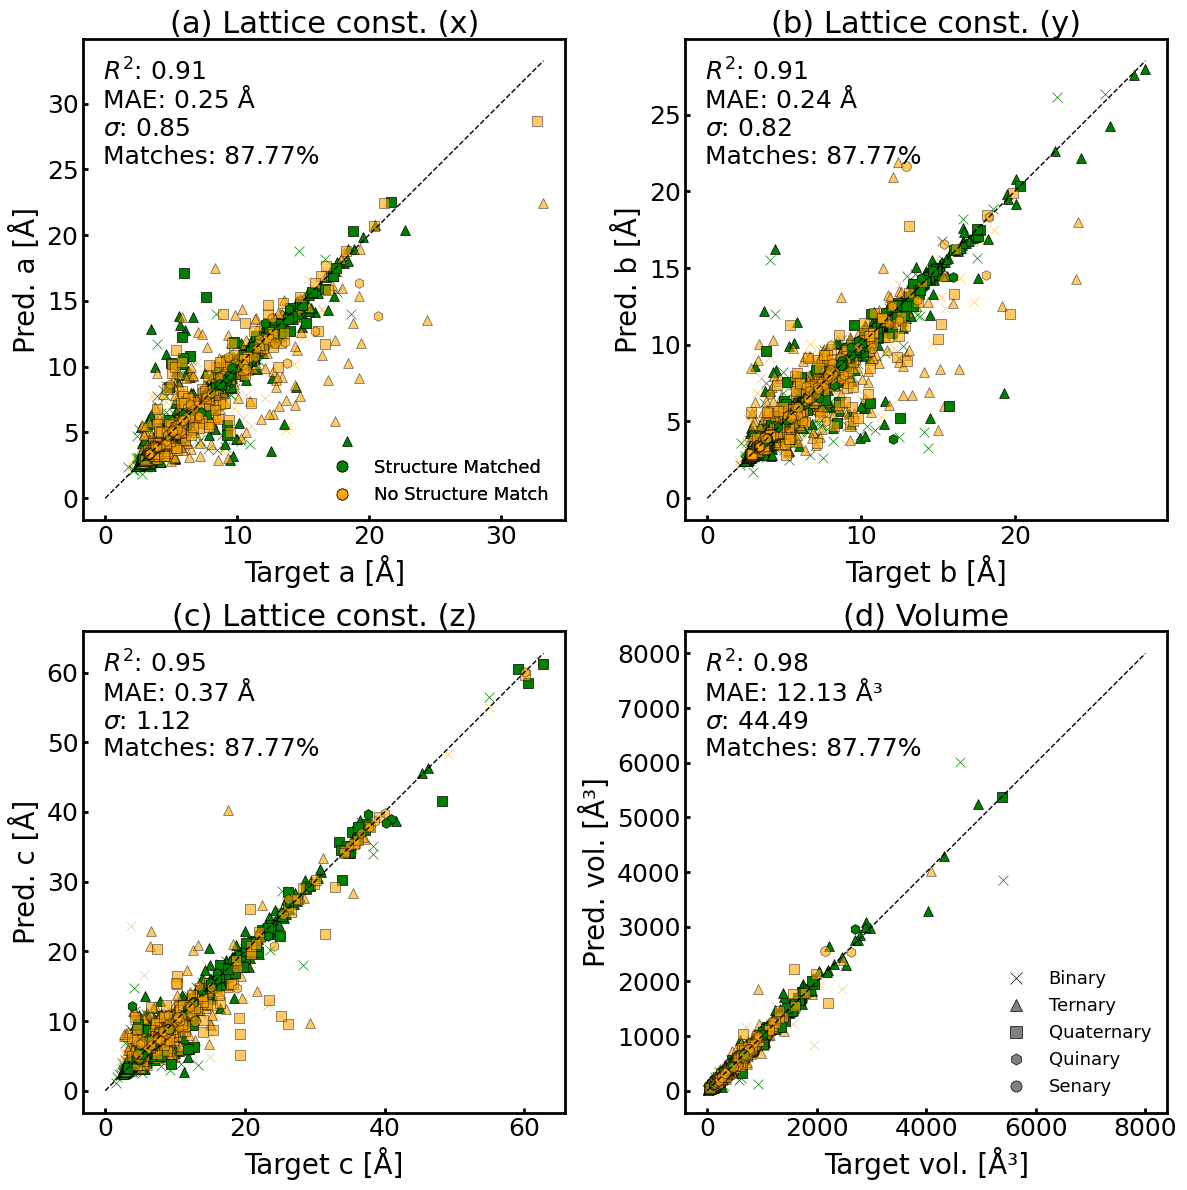

In [5]:
plot_true_vs_gen(
    df_metrics_2,
    figsize=(12, 12),
    title_fontsize=22,
    label_fontsize=20,
    ticks_fontsize=18,
    legend_fontsize=13,
    annot_fontsize=18,
    scatter_size=50,
    scatter_edge_width=0.5,
    alpha_matched=1.0,
    alpha_unmatched=0.6,
    diag_line_width=1.0,
    axes_linewidth=2.0
    )

In [6]:

df_metrics = pd.read_parquet('_utils/_evaluation_conditional/evaluation_files/XRD/COD/COD-small-XRD-test-nohc-10T15K_metrics.parquet')
df_metrics.head()

# dont remove where RMS-d is NaN
df_metrics[['Gen a', 'Gen b', 'Gen c', 'Gen volume']] = df_metrics['Gen Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics[['True a', 'True b', 'True c', 'True volume']] = df_metrics['True Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics['System'] = df_metrics['True Struct'].apply(get_system_type)

# print amount of rows with None in True a
print(f"Number of rows with None in True a: {df_metrics['True a'].isna().sum()}")
print("Max System type:", df_metrics['System'].max())

# Mean in RMS-d for rows where RMS-d is not NaN
mean_rmsd = df_metrics['RMS-d'].mean()
print(f"Mean RMS-d (excluding NaNs): {mean_rmsd:.3f}")


Number of rows with None in True a: 0
Max System type: 6
Mean RMS-d (excluding NaNs): 0.052


Number of rows with None values: 116
Percentage of matches: 41.41%

Property        Subset          R²       MAE      σ        N       
a               Total           0.753    0.834    1.590    196     
                Matched         0.734    1.033    1.765    81      
                Non-matched     0.838    0.694    1.266    115     
--------------------------------------------------------------------------------
b               Total           0.825    0.691    1.543    196     
                Matched         0.956    0.282    0.633    81      
                Non-matched     0.767    0.980    1.937    115     
--------------------------------------------------------------------------------
c               Total           0.862    0.994    1.642    196     
                Matched         0.872    1.015    1.738    81      
                Non-matched     0.851    0.979    1.544    115     
--------------------------------------------------------------------------------
volume   

/tmp/ipykernel_2200627/2218039296.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[green_system_mask], y[green_system_mask],


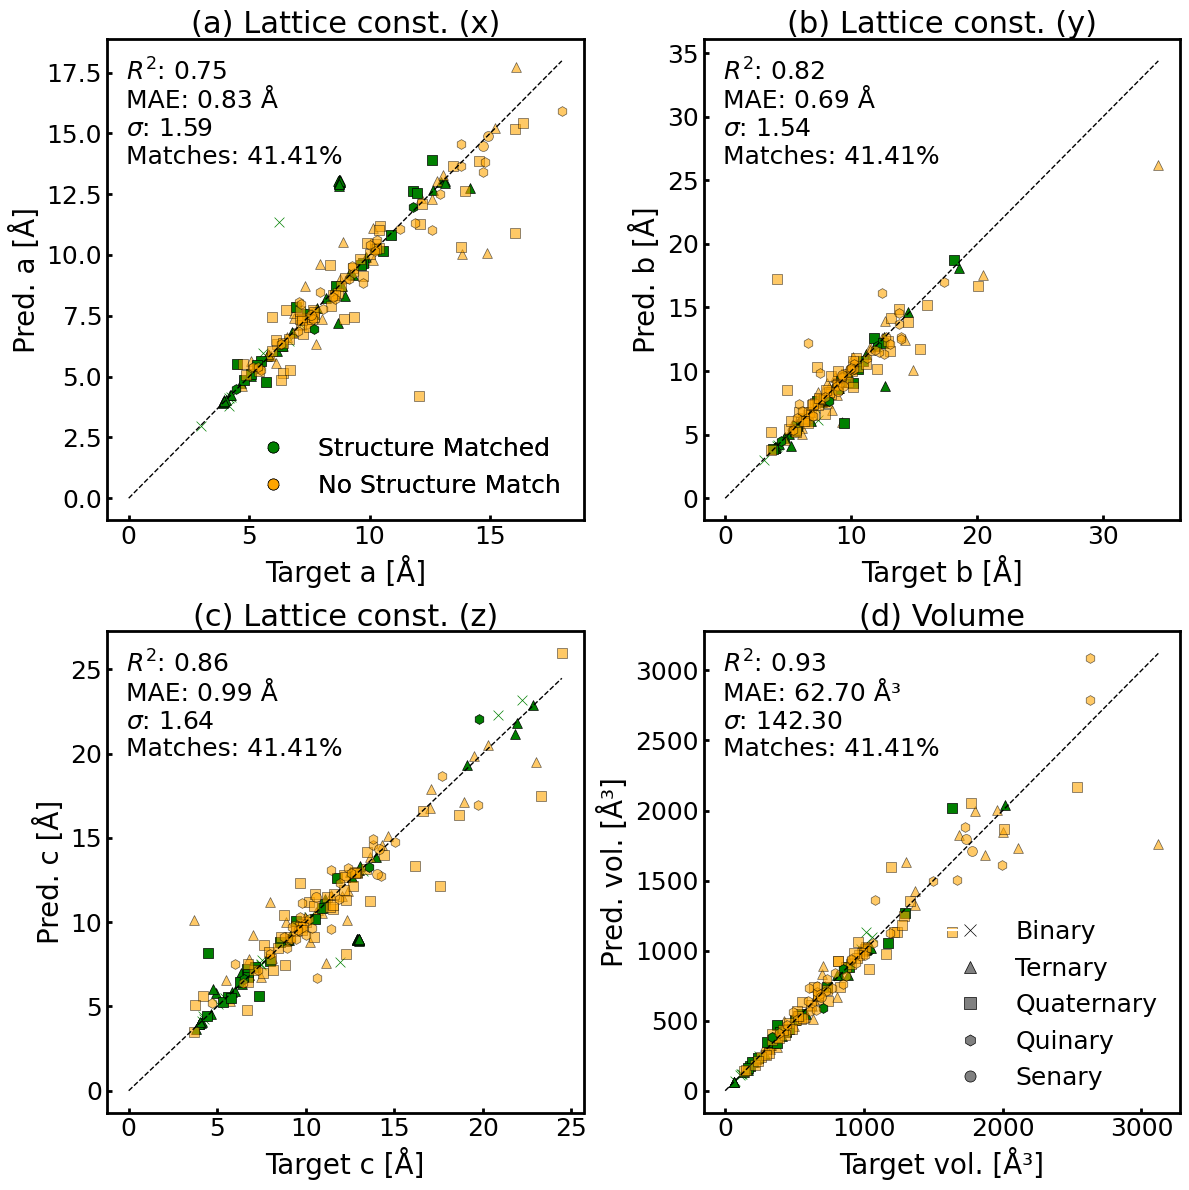

In [7]:
plot_true_vs_gen(
    df_metrics,
    figsize=(12, 12),
    title_fontsize=22,
    label_fontsize=20,
    ticks_fontsize=18,
    legend_fontsize=18,
    annot_fontsize=18,
    scatter_size=50,
    scatter_edge_width=0.5,
    alpha_matched=1.0,
    alpha_unmatched=0.6,
    diag_line_width=1.0,
    axes_linewidth=2.0
    )

In [8]:
from _utils import extract_numeric_property, get_unit_cell_volume, extract_space_group_symbol

# read _utils/_evaluation_conditional/evaluation_files/comp-jarvis-XRD-test_metrics.parquet with pandas
df_metrics_3 = pd.read_parquet('_utils/_evaluation_conditional/evaluation_files/XRD/COD/COD-small-XRD-test-nohc-mgen-10T15K_metrics.parquet')
df_metrics_3.head()

# dont remove where RMS-d is NaN
df_metrics_3[['Gen a', 'Gen b', 'Gen c', 'Gen volume']] = df_metrics_3['Gen Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics_3[['True a', 'True b', 'True c', 'True volume']] = df_metrics_3['True Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics_3['System'] = df_metrics_3['True Struct'].apply(get_system_type)
# print amount of rows with None in True a
print(f"Number of rows with None in True a: {df_metrics_3['True a'].isna().sum()}")
print(f"Max value in 'System' column: {df_metrics_3['System'].max()}")

# Mean in RMS-d for rows where RMS-d is not NaN
mean_rmsd = df_metrics_3['RMS-d'].mean()
print(f"Mean RMS-d (excluding NaNs): {mean_rmsd:.3f}")



Number of rows with None in True a: 0
Max value in 'System' column: 6
Mean RMS-d (excluding NaNs): 0.042


Number of rows with None values: 156
Percentage of matches: 21.21%

Property        Subset          R²       MAE      σ        N       
a               Total           0.591    1.152    1.964    196     
                Matched         0.843    0.272    1.102    42      
                Non-matched     0.505    1.392    2.126    154     
--------------------------------------------------------------------------------
b               Total           0.653    1.146    2.173    196     
                Matched         0.996    0.121    0.181    42      
                Non-matched     0.578    1.425    2.450    154     
--------------------------------------------------------------------------------
c               Total           0.805    1.138    1.958    196     
                Matched         0.974    0.405    0.969    42      
                Non-matched     0.702    1.338    2.143    154     
--------------------------------------------------------------------------------
volume   

/tmp/ipykernel_2200627/2218039296.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[green_system_mask], y[green_system_mask],
/tmp/ipykernel_2200627/2218039296.py:100: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[orange_system_mask], y[orange_system_mask],


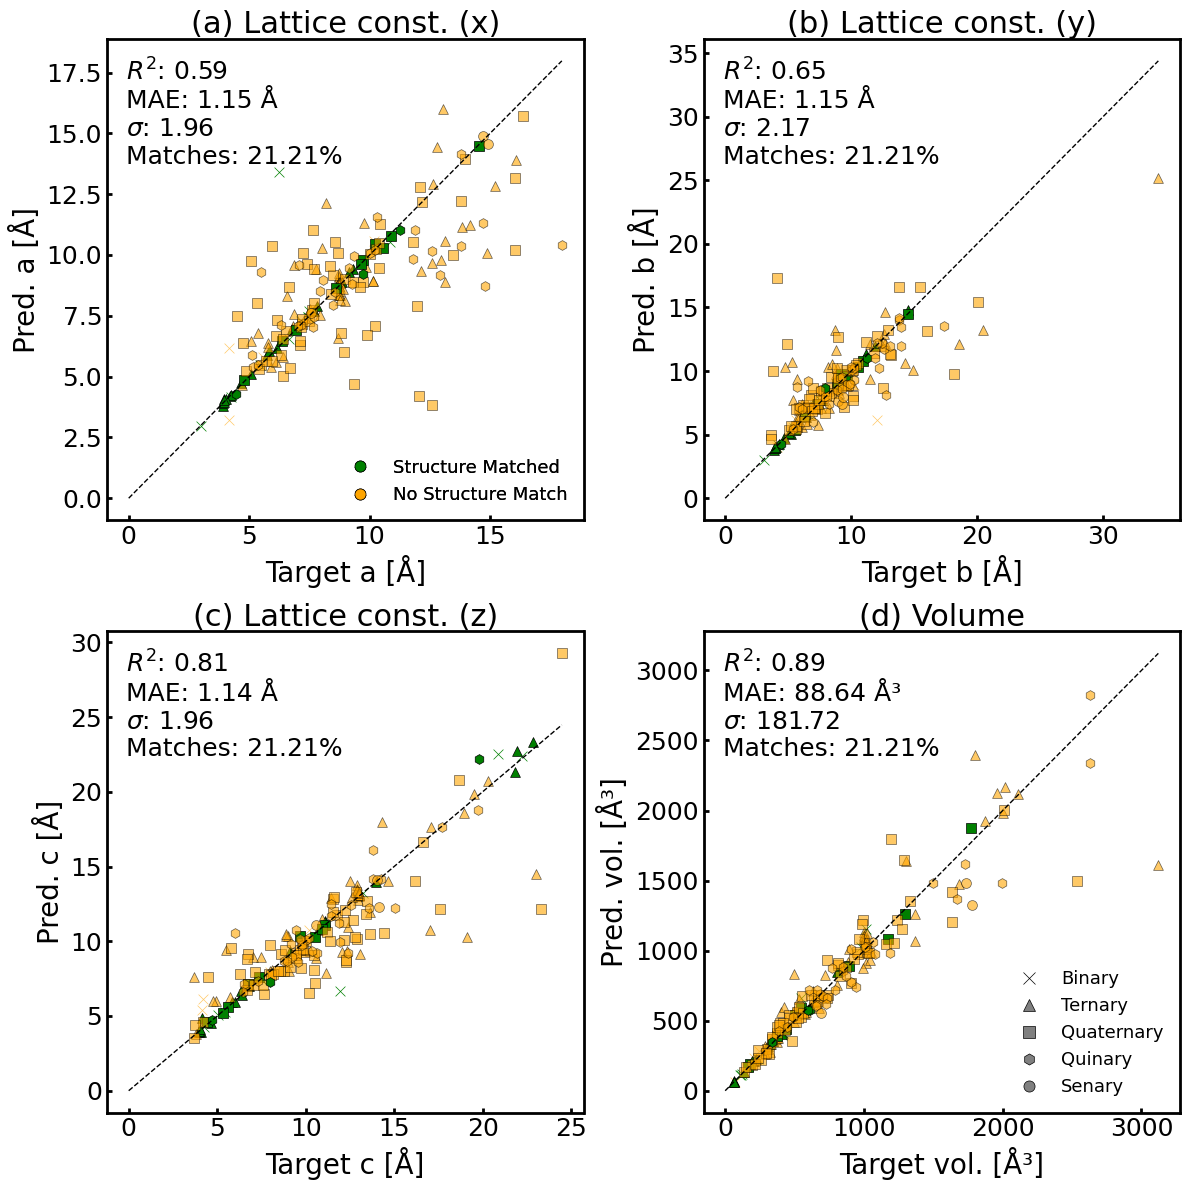

In [10]:
plot_true_vs_gen(
    df_metrics_3,
    figsize=(12, 12),
    title_fontsize=22,
    label_fontsize=20,
    ticks_fontsize=18,
    legend_fontsize=13,
    annot_fontsize=18,
    scatter_size=50,
    scatter_edge_width=0.5,
    alpha_matched=1.0,
    alpha_unmatched=0.6,
    diag_line_width=1.0,
    axes_linewidth=2.0
    )

In [11]:
from _utils import extract_numeric_property, get_unit_cell_volume, extract_space_group_symbol

# read _utils/_evaluation_conditional/evaluation_files/comp-jarvis-XRD-test_metrics.parquet with pandas
df_metrics_4 = pd.read_parquet('_utils/_evaluation_conditional/evaluation_files/XRD/COD/COD-small-XRD-nohc-test-uncond_metrics.parquet')
df_metrics_4.head()

# dont remove where RMS-d is NaN
df_metrics_4[['Gen a', 'Gen b', 'Gen c', 'Gen volume']] = df_metrics_4['Gen Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics_4[['True a', 'True b', 'True c', 'True volume']] = df_metrics_4['True Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
# print amount of rows with None in True a
print(f"Number of rows with None in True a: {df_metrics_4['True a'].isna().sum()}")
df_metrics_4['System'] = df_metrics_4['True Struct'].apply(get_system_type)
print(f"Max value in 'System' column: {df_metrics_4['System'].max()}")
# Mean in RMS-d for rows where RMS-d is not NaN
mean_rmsd = df_metrics_4['RMS-d'].mean()
print(f"Mean RMS-d (excluding NaNs): {mean_rmsd:.3f}")


Error extracting lattice parameters for cif: None
Error: expected string or bytes-like object
Error extracting lattice parameters for cif: None
Error: expected string or bytes-like object
Error extracting lattice parameters for cif: None
Error: expected string or bytes-like object
Number of rows with None in True a: 0
Max value in 'System' column: 6
Mean RMS-d (excluding NaNs): 0.047


Number of rows with None values: 143
Percentage of matches: 27.78%

Property        Subset          R²       MAE      σ        N       
a               Total           0.695    0.949    1.774    193     
                Matched         0.993    0.148    0.238    55      
                Non-matched     0.556    1.268    2.092    138     
--------------------------------------------------------------------------------
b               Total           0.599    1.090    2.345    193     
                Matched         0.995    0.176    0.260    55      
                Non-matched     0.432    1.454    2.768    138     
--------------------------------------------------------------------------------
c               Total           0.780    1.207    2.140    193     
                Matched         0.990    0.325    0.597    55      
                Non-matched     0.608    1.558    2.501    138     
--------------------------------------------------------------------------------
volume   

/tmp/ipykernel_2200627/2218039296.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[green_system_mask], y[green_system_mask],


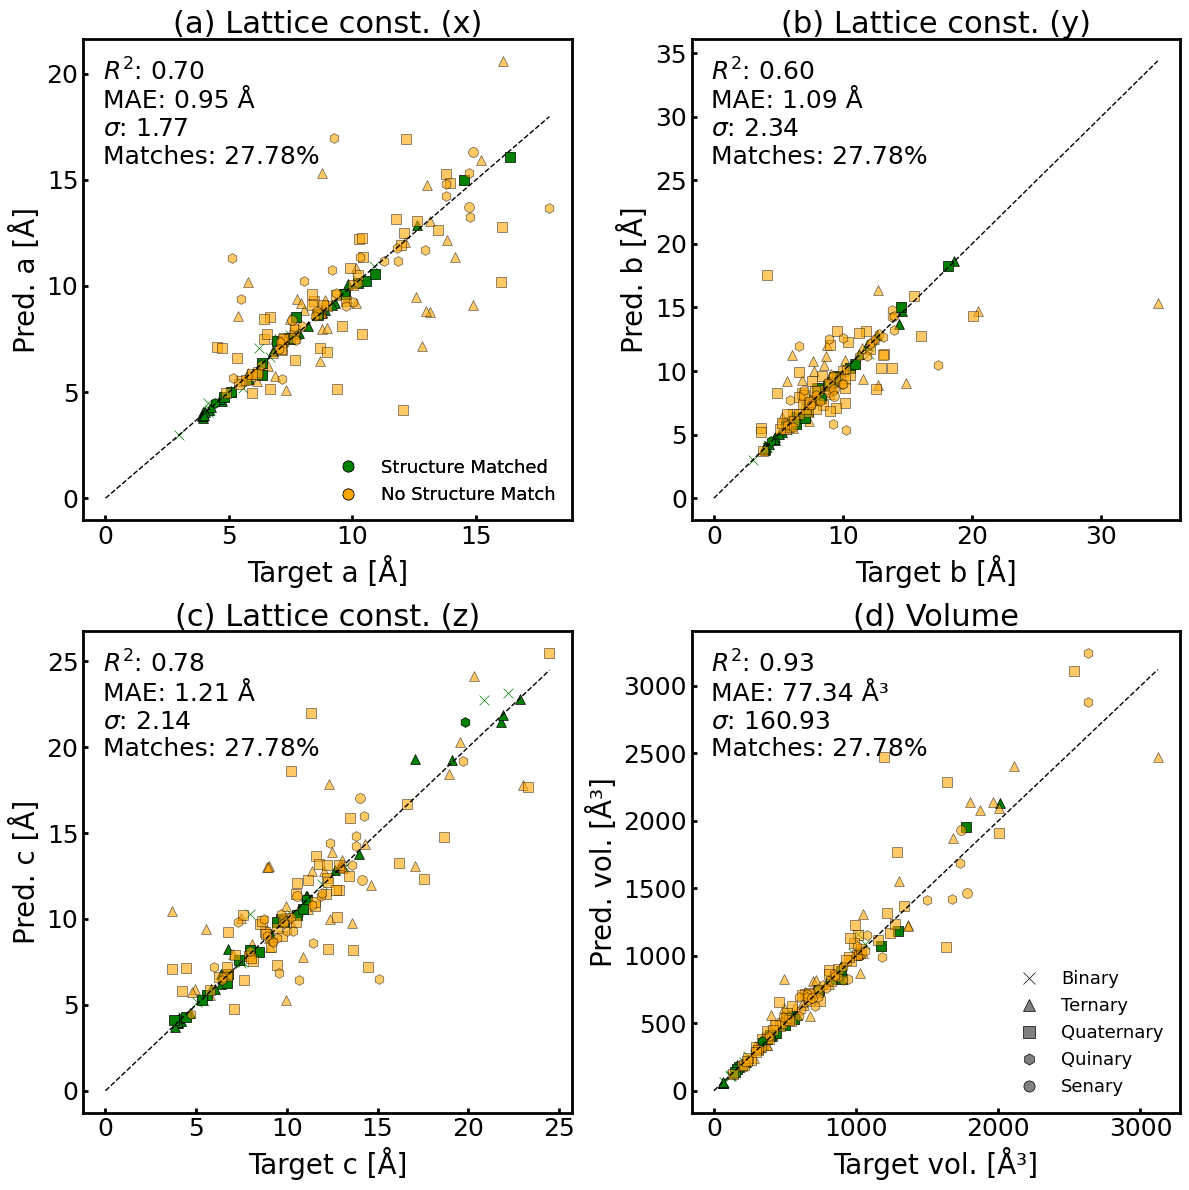

In [12]:
plot_true_vs_gen(
    df_metrics_4,
    figsize=(12, 12),
    title_fontsize=22,
    label_fontsize=20,
    ticks_fontsize=18,
    legend_fontsize=13,
    annot_fontsize=18,
    scatter_size=50,
    scatter_edge_width=0.5,
    alpha_matched=1.0,
    alpha_unmatched=0.6,
    diag_line_width=1.0,
    axes_linewidth=2.0
    )

In [25]:
from _utils import extract_numeric_property, get_unit_cell_volume, extract_space_group_symbol

# read _utils/_evaluation_conditional/evaluation_files/comp-jarvis-XRD-test_metrics.parquet with pandas
df_metrics_5 = pd.read_parquet('_utils/_evaluation_conditional/evaluation_files/amil-TiO2_metrics.parquet')
df_metrics_5.head()

# dont remove where RMS-d is ~NaN
df_metrics_5[['Gen a', 'Gen b', 'Gen c', 'Gen volume']] = df_metrics_5['Gen Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
df_metrics_5[['True a', 'True b', 'True c', 'True volume']] = df_metrics_5['True Struct'].apply(lambda x: pd.Series(extract_lattice_params_and_volume(x)))
# print amount of rows with None in True a
print(f"Number of rows with None in True a: {df_metrics_5['True a'].isna().sum()}")
df_metrics_5['System'] = df_metrics_5['True Struct'].apply(get_system_type)
print(f"Max value in 'System' column: {df_metrics_5['System'].max()}")
# Mean in RMS-d for rows where RMS-d is not NaN
mean_rmsd = df_metrics_5['RMS-d'].mean()
print(f"Mean RMS-d (excluding NaNs): {mean_rmsd:.3f}")


Number of rows with None in True a: 0
Max value in 'System' column: 2
Mean RMS-d (excluding NaNs): 0.076


Number of rows with None values: 0
Percentage of matches: 100.00%

Property        Subset          R²       MAE      σ        N       
a               Total           0.865    0.177    0.242    3       
                Matched         0.865    0.177    0.242    3       
                Non-matched     nan      nan      nan      0       
--------------------------------------------------------------------------------
b               Total           0.833    1.255    1.739    3       
                Matched         0.833    1.255    1.739    3       
                Non-matched     nan      nan      nan      0       
--------------------------------------------------------------------------------
c               Total           0.369    2.035    2.642    3       
                Matched         0.369    2.035    2.642    3       
                Non-matched     nan      nan      nan      0       
--------------------------------------------------------------------------------
volume    

/tmp/ipykernel_2200627/2218039296.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[green_system_mask], y[green_system_mask],


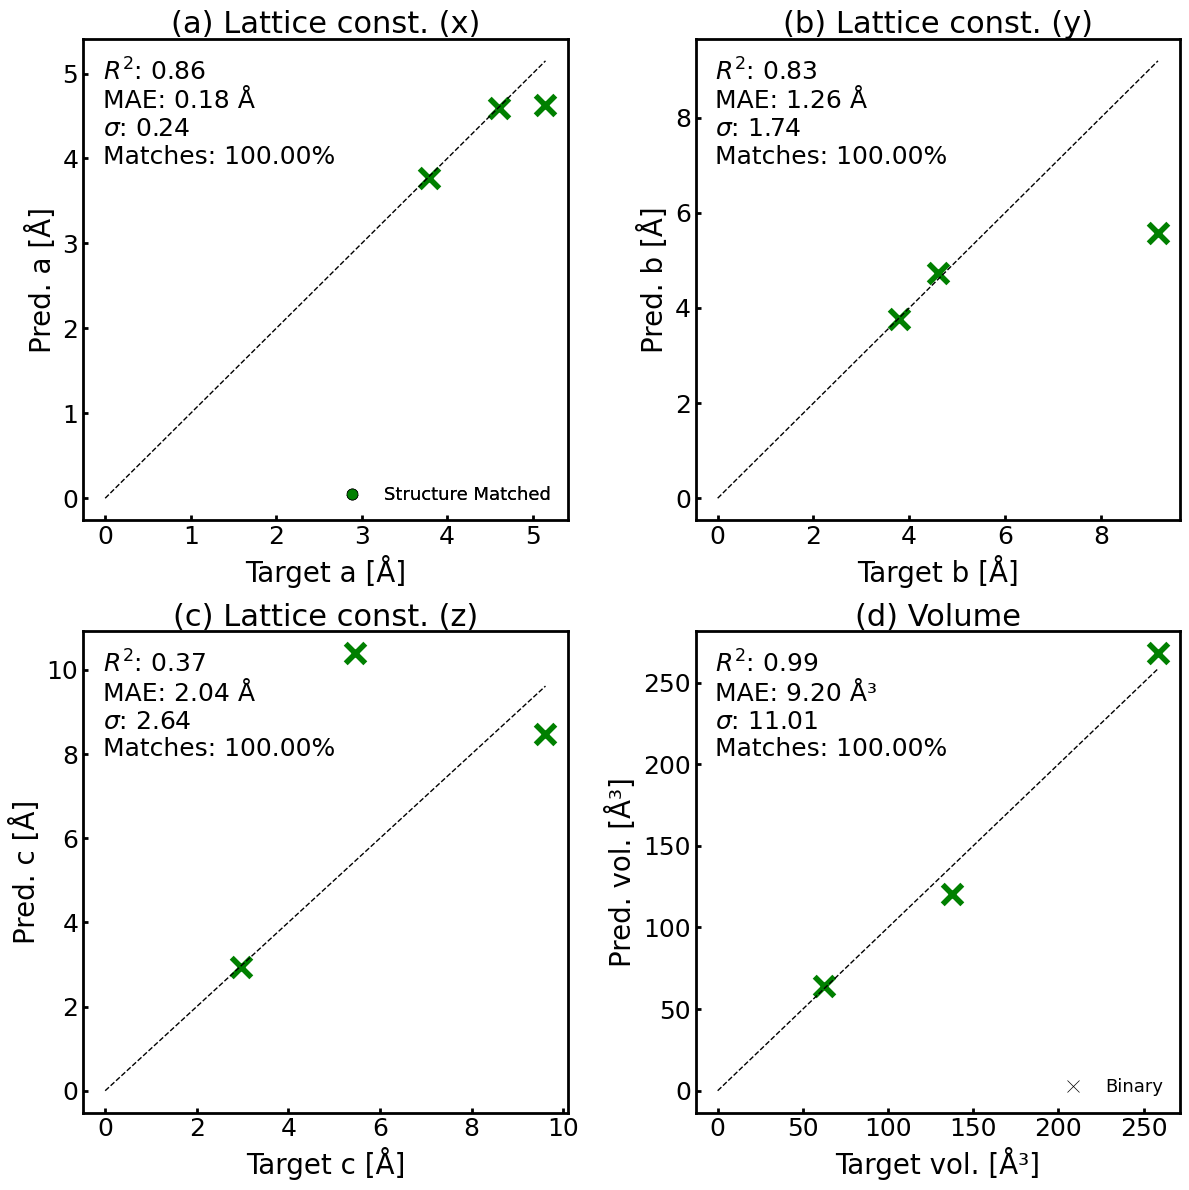

In [26]:
plot_true_vs_gen(
    df_metrics_5,
    figsize=(12, 12),
    title_fontsize=22,
    label_fontsize=20,
    ticks_fontsize=18,
    legend_fontsize=13,
    annot_fontsize=18,
    scatter_size=200,
    scatter_edge_width=4.0,
    alpha_matched=1.0,
    alpha_unmatched=0.6,
    diag_line_width=1.0,
    axes_linewidth=2.0
    )

# Random

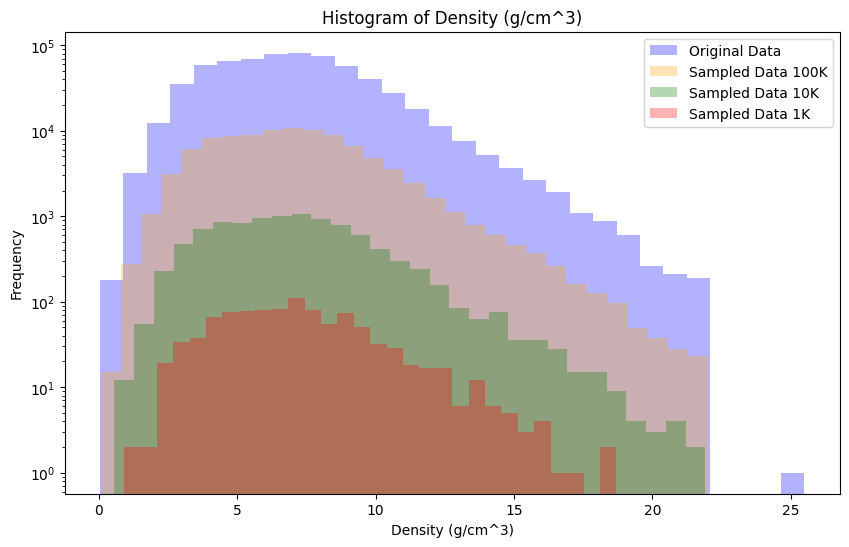

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
# set new path
os.chdir('/home/cyprien/CrystaLLMv2_PKV')

df = pd.read_parquet('HF-databases/mattergen_dev/mattergen_den_ehull_clean.parquet')
df2 = pd.read_parquet('HF-databases/mattergen_dev/mattergen_den_ehull_clean_100K.parquet')
df3 = pd.read_parquet('HF-databases/mattergen_dev/mattergen_den_ehull_clean_10K.parquet')
df4 = pd.read_parquet('HF-databases/mattergen_dev/mattergen_den_ehull_clean_1K.parquet')

plt.figure(figsize=(10, 6))
plt.hist(df['Density (g/cm^3)'], bins=30, alpha=0.3, label='Original Data', color='blue', density=False)
plt.hist(df2['Density (g/cm^3)'], bins=30, alpha=0.3, label='Sampled Data 100K', color='orange', density=False)
plt.hist(df3['Density (g/cm^3)'], bins=30, alpha=0.3, label='Sampled Data 10K', color='green', density=False)
plt.hist(df4['Density (g/cm^3)'], bins=30, alpha=0.3, label='Sampled Data 1K', color='red', density=False)

plt.legend()
plt.yscale('log')
plt.xlabel('Density (g/cm^3)')
plt.ylabel('Frequency')
plt.title('Histogram of Density (g/cm^3)')
plt.show()